In [11]:
# final_project_bigdata.py

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, Dataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
from tqdm.auto import tqdm # Use auto version for better notebook/script compatibility
import joblib # For saving scalers/encoders
import math
import os
import glob
import shutil
import gc # Garbage collection
from pathlib import Path
from matplotlib.patches import Patch

# --- Configuration ---
# These parameters are kept from the original main call
DATA_PATH = 'diabetes.csv' # Input CSV file path
PROCESSED_DATA_DIR = 'processed_data' # Directory to store intermediate processed chunks
ENCODED_DATA_DIR = 'encoded_data' # Directory to store encoded data chunks
CLUSTER_ASSIGNMENTS_DIR = 'cluster_assignments' # Directory to store cluster assignments
MODEL_SAVE_PATH = 'interpretable_autoencoder.pth'
CHUNK_SIZE = 10000  # Adjust based on available memory
ENCODING_DIM = 8
N_CLUSTERS = 6
EPOCHS = 2
LEARNING_RATE = 0.001
BATCH_SIZE = 256 # Training batch size
L1_WEIGHT = 0.00050
ORTHOGONALITY_WEIGHT = 0.04
VALIDATION_SPLIT = 0.2 # Use 20% of chunks for validation
RANDOM_SEED = 42
PLOT_SAMPLE_SIZE = 5000 # Number of points to sample for scatter plots etc. if needed

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# --- Helper Functions ---
def safe_mkdir(path):
    """Creates a directory if it doesn't exist."""
    Path(path).mkdir(parents=True, exist_ok=True)

def cleanup_dir(path):
    """Removes a directory and its contents if it exists."""
    if os.path.exists(path):
        shutil.rmtree(path)

# --- Preprocessing Function (Chunked) ---

# --- PySpark Specific Imports ---
# Ensure PySpark is installed and configured in your environment
try:
    from pyspark.sql import SparkSession
    import pyspark.sql.functions as F
    from pyspark.sql.types import StringType, IntegerType, DoubleType, StructType, StructField
    print("PySpark imported successfully.")
    spark_available = True
except ImportError:
    print("Warning: PySpark not found. Preprocessing will fail.")
    print("Please install pyspark: pip install pyspark")
    spark_available = False
    # Define dummy SparkSession to avoid errors later if not imported
    class DummySparkSession:
        def builder(self): return self
        def appName(self, name): return self
        def getOrCreate(self): return self
        def read(self): raise RuntimeError("PySpark not available")
        def stop(self): pass
    SparkSession = DummySparkSession

# --- Preprocessing Function (Pass 1 - Using PySpark) ---

def fit_preprocess_components(data_path, chunk_size, top_n_drugs=160): # Signature unchanged
    """
    First pass through the data using PySpark to fit scalers, encoders, and find top N drugs.
    Fits scikit-learn components on the driver using statistics gathered by Spark.
    CHUNK_SIZE parameter is ignored as Spark reads the whole file.
    """
    if not spark_available:
        raise RuntimeError("PySpark is required for fit_preprocess_components but is not installed.")

    print(f"--- Starting Preprocessing Pass 1 (PySpark): Fitting Scalers/Encoders & Finding Top {top_n_drugs} Drugs ---")

    # Configure Spark Session (adjust memory and cores as needed)
    # Using local[*] to use all available cores. Set master URL if running on a cluster.
    spark = SparkSession.builder \
        .appName("PreprocessingPass1") \
        .config("spark.driver.memory", "4g") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .master("local[*]") \
        .getOrCreate()

    try:
        # Define features (Unchanged from original logic)
        numerical_features = ['age', 'wt']
        categorical_features = ['drugname', 'gndr_cod']
        target_outcome_codes = ['DE', 'LT', 'HO', 'DS', 'CA', 'RI', 'OT']
        # Identify columns where NA values are critical for fitting components (excluding drugname for now)
        critical_cols_for_na = ['age', 'gndr_cod', 'wt', 'outc_cod'] + [f for f in categorical_features if f != 'drugname']

        # Read data using Spark
        # Infer schema, handle headers, convert column names to lowercase
        print(f"Reading data from {data_path} using Spark...")
        df = spark.read.csv(data_path, header=True, inferSchema=True)
        original_columns = df.columns
        new_columns = [col.lower() for col in original_columns]
        df = df.toDF(*new_columns) # Rename columns to lowercase
        total_rows_processed = df.count()
        print(f"Read {total_rows_processed} rows.")

        # --- Count Drugs (Spark) ---
        print("Counting drug occurrences...")
        # Ensure drugname exists and handle potential nulls before counting
        if 'drugname' in df.columns:
            drug_counts_df = df.select("drugname").na.drop(subset=["drugname"]) \
                               .withColumn("drugname", F.col("drugname").cast(StringType())) \
                               .groupBy("drugname").count()
            drug_count_rows = drug_counts_df.count() # Check if any drugs were found
        else:
            print("Warning: 'drugname' column not found. Cannot identify top drugs.")
            drug_counts_df = None
            drug_count_rows = 0


        # --- Determine Top N Drugs (Collect to Driver) ---
        if drug_counts_df is None or drug_count_rows == 0:
             print("Warning: No non-null drug names found or counted.")
             top_drugs_list = []
        else:
            # Collect top N drug names to the driver
            top_drugs_rows = drug_counts_df.orderBy(F.desc("count")).limit(top_n_drugs).select("drugname").collect()
            top_drugs_list = [row.drugname for row in top_drugs_rows]
            print(f"Identified the top {len(top_drugs_list)} most frequent drugs.")
            if len(top_drugs_list) < top_n_drugs:
                print(f"Warning: Found fewer than {top_n_drugs} unique drugs ({len(top_drugs_list)}).")

        # --- Filter for Stats Calculation (Spark) ---
        # Drop rows where critical non-drug columns are NA
        print("Filtering rows with NA in critical columns for fitting statistics...")
        df_filtered_for_stats = df.dropna(subset=critical_cols_for_na)
        valid_rows_count_pre_filter = df_filtered_for_stats.count()
        print(f"Found {valid_rows_count_pre_filter} rows with non-NA values in critical non-drug columns.")

        if valid_rows_count_pre_filter == 0:
            spark.stop()
            raise ValueError("No valid rows found after filtering NAs for stats calculation. Check input data.")

        # Cache the filtered data as it's used multiple times
        df_filtered_for_stats.cache()
        print(f"Cached DataFrame with {valid_rows_count_pre_filter} rows for statistics calculation.")

        # --- Calculate Statistics for StandardScaler (Spark) ---
        print("Calculating mean and standard deviation for numerical features...")
        stats_agg = []
        for feature in numerical_features:
            # Ensure numerical columns are treated as numbers (e.g., double) before calculating stats
            # Handle potential type errors during cast if needed
            try:
                df_filtered_for_stats = df_filtered_for_stats.withColumn(feature, F.col(feature).cast(DoubleType()))
                stats_agg.append(F.mean(feature).alias(f"{feature}_mean"))
                stats_agg.append(F.stddev(feature).alias(f"{feature}_std"))
            except Exception as e:
                 print(f"Error casting or adding aggregation for numerical feature '{feature}': {e}")
                 # Decide how to handle - skip feature? raise error?
                 # For now, raise error to alert user
                 spark.stop()
                 raise ValueError(f"Failed to process numerical feature '{feature}' for scaling.")


        # Compute stats in one pass
        stats_results = df_filtered_for_stats.agg(*stats_agg).collect()

        if not stats_results:
             spark.stop()
             raise ValueError("Failed to calculate statistics for numerical features.")

        stats_row = stats_results[0] # Get the single row of results

        # --- Fit scikit-learn StandardScaler on Driver using Spark Stats ---
        print("Fitting StandardScaler on driver using calculated statistics...")
        scaler = StandardScaler(with_mean=True, with_std=True)
        scaler.mean_ = np.array([stats_row[f"{feature}_mean"] if stats_row[f"{feature}_mean"] is not None else 0.0 for feature in numerical_features])
        # Handle potential null stddev (if only one distinct value) -> replace with 1.0 to avoid division by zero
        scaler.scale_ = np.array([stats_row[f"{feature}_std"] if stats_row[f"{feature}_std"] is not None and stats_row[f"{feature}_std"] > 1e-9 else 1.0 for feature in numerical_features])
        scaler.n_features_in_ = len(numerical_features)
        # Explicitly check for near-zero std deviation again and set scale to 1
        scaler.scale_[np.isclose(scaler.scale_, 0)] = 1.0
        scaler.var_ = scaler.scale_**2 # Set variance attribute as well
        print("StandardScaler fitted.")
        print(f"  Means: {scaler.mean_}")
        print(f"  Scales (Std Dev): {scaler.scale_}")


        # --- Collect Unique Categories for NON-DRUG features (Spark -> Driver) ---
        print("Collecting unique categories for non-drug categorical features...")
        unique_categories = {}
        for feature in categorical_features:
            if feature != 'drugname':
                # Ensure column exists before collecting distinct values
                if feature in df_filtered_for_stats.columns:
                    try:
                        # Cast to string, drop nulls, get distinct, collect to driver
                        distinct_values = df_filtered_for_stats.select(feature).na.drop(subset=[feature]) \
                                                          .withColumn(feature, F.col(feature).cast(StringType())) \
                                                          .distinct().collect()
                        # Sort values for consistent encoder fitting
                        unique_categories[feature] = sorted([row[feature] for row in distinct_values])
                        print(f"  Found {len(unique_categories[feature])} unique values for '{feature}'")
                    except Exception as e:
                        print(f"Error collecting unique categories for feature '{feature}': {e}")
                        # Decide handling: skip feature? raise error?
                        unique_categories[feature] = [] # Default to empty list if error occurs
                else:
                    print(f"Warning: Categorical feature '{feature}' not found in filtered DataFrame. Skipping.")
                    unique_categories[feature] = []


        # --- Fit scikit-learn OneHotEncoders on Driver ---
        print("Fitting OneHotEncoders on driver...")
        encoders = {}
        all_feature_names_post_ohe = list(numerical_features) # Start with numerical names

        for feature in categorical_features:
            if feature == 'drugname':
                # Use the exact top N drugs list as categories
                categories = sorted(top_drugs_list) # Sort for consistency
                if not categories:
                    print(f"Warning: No top drugs identified for feature '{feature}'. Skipping encoder fitting.")
                    encoders[feature] = None
                    continue
                # Add the drugname feature names to the list
                all_feature_names_post_ohe.extend([f"{feature}_{cat}" for cat in categories])
            else:
                # Use collected unique categories for other features
                categories = unique_categories.get(feature, [])
                if not categories:
                    print(f"Warning: No categories found or collected for feature '{feature}'. Skipping encoder fitting.")
                    encoders[feature] = None
                    continue
                 # Add other categorical feature names
                all_feature_names_post_ohe.extend([f"{feature}_{cat}" for cat in categories])

            # Fit scikit-learn encoder
            # handle_unknown='ignore' means new categories at transform time will become all zeros
            encoder = OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')
            # Fit requires dummy data matching shape: needs a 2D array like [[category]]
            # Use the first category found to fit the structure
            if categories:
                 # Use np.array([[category]]) which is 2D
                 encoder.fit(np.array([[categories[0]]]))
                 encoders[feature] = encoder
                 print(f"  Fitted encoder for '{feature}' with {len(categories)} categories.")
            else:
                 # This case should have been caught by the `if not categories` check above
                 encoders[feature] = None

        # Unpersist the cached DataFrame
        df_filtered_for_stats.unpersist()
        print("Unpersisted cached DataFrame.")

        # Define target mapping and names (Unchanged)
        outcome_mapping = {
            'DE': 'de', 'LT': 'lt', 'HO': 'ho', 'DS': 'ds',
            'CA': 'ca', 'RI': 'ri', 'OT': 'ot'
        }
        target_features = list(outcome_mapping.values())

        # Save fitted components (scikit-learn objects) (Unchanged)
        joblib.dump(scaler, 'scaler.joblib')
        joblib.dump(encoders, 'encoders.joblib')

        print("--- Preprocessing Pass 1 (PySpark) Finished: Scaler, Encoders Saved ---")
        # Return fitted sklearn components, top_drugs_list, feature names etc.
        return (scaler, encoders, top_drugs_list, numerical_features,
                categorical_features, target_features, outcome_mapping,
                valid_rows_count_pre_filter, all_feature_names_post_ohe)

    except Exception as e:
        # Ensure Spark stops even if an error occurs
        print(f"An error occurred during Preprocessing Pass 1: {e}")
        import traceback
        traceback.print_exc()
        # Re-raise the exception after stopping Spark
        if 'spark' in locals() and spark.sparkContext._jsc is not None:
            spark.stop()
        raise e
    finally:
        # Final check to stop Spark session if it's still running
        if 'spark' in locals() and spark.sparkContext._jsc is not None:
            print("Stopping Spark session for Pass 1.")
            spark.stop()


# --- Preprocessing Function (Pass 2 - Using PySpark) ---

def preprocess_data_chunked(data_path, output_dir, chunk_size, scaler, encoders, top_drugs_list, numerical_features, categorical_features, target_features, outcome_mapping):
    """
    Second pass using PySpark: Filter by top drugs, apply transformations stored
    in the driver-side scikit-learn scaler/encoders, and save processed data as parquet files.
    CHUNK_SIZE parameter is ignored as Spark reads the whole file.
    """
    if not spark_available:
        raise RuntimeError("PySpark is required for preprocess_data_chunked but is not installed.")

    print(f"--- Starting Preprocessing Pass 2 (PySpark): Filtering by Top {len(top_drugs_list)} Drugs, Transforming Data ---")
    safe_mkdir(output_dir)
    cleanup_dir(output_dir) # Clear previous processed data
    safe_mkdir(output_dir)

    # Configure Spark Session
    spark = SparkSession.builder \
        .appName("PreprocessingPass2") \
        .config("spark.driver.memory", "4g") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .master("local[*]") \
        .getOrCreate()

    try:
        # Read data again
        print(f"Reading data from {data_path} using Spark...")
        df = spark.read.csv(data_path, header=True, inferSchema=True)
        original_columns = df.columns
        new_columns = [col.lower() for col in original_columns]
        df = df.toDF(*new_columns) # Rename columns to lowercase
        initial_count = df.count()
        print(f"Read {initial_count} rows.")

        # --- Filter by Top N Drugs FIRST (Spark) ---
        if 'drugname' not in df.columns:
            print(f"Warning: 'drugname' column missing in the data. Cannot filter by drugs.")
            # Proceeding without drug filtering. Add a check if this is required.
            # if not top_drugs_list: # Only allow if top_drugs_list is empty intentionally?
            #     spark.stop()
            #     raise ValueError("'drugname' column not found, but top_drugs_list is not empty.")
        elif not top_drugs_list:
             print("Info: top_drugs_list is empty, skipping drug filtering.")
        else:
            print(f"Filtering rows to keep only top {len(top_drugs_list)} drugs...")
            # Broadcast the list for efficiency if it's large, otherwise simple isin is fine
            # Convert list to set for slightly faster lookup in isin
            top_drugs_set = set(top_drugs_list)
            # broadcast_top_drugs = spark.sparkContext.broadcast(top_drugs_set) # Broadcast if list is large
            df = df.withColumn("drugname", F.col("drugname").cast(StringType())) # Ensure string type
            df = df.filter(F.col("drugname").isin(top_drugs_set)) # Use set directly
            count_after_drug_filter = df.count()
            print(f"{count_after_drug_filter} rows remaining after drug filtering.")
            if count_after_drug_filter == 0 and initial_count > 0:
                 print("Warning: No rows remain after filtering by top drugs.")
                 # Decide behavior: continue (might lead to errors later) or stop?
                 # spark.stop()
                 # raise ValueError("No data left after filtering for top drugs.")


        # --- Now Drop NA based on other critical columns for the FILTERED data (Spark) ---
        print("Dropping rows with NA in critical columns...")
        # Define critical columns again, excluding drugname as it was handled or might be missing
        cols_to_check_na = numerical_features + [f for f in categorical_features if f != 'drugname'] + ['outc_cod']
        # Ensure columns exist before trying to drop NAs
        cols_to_check_na = [c for c in cols_to_check_na if c in df.columns]
        if not cols_to_check_na:
             print("Warning: No critical columns found to check for NA values.")
        else:
             df = df.dropna(subset=cols_to_check_na)

        count_after_na_drop = df.count()
        print(f"{count_after_na_drop} rows remaining after NA drop.")

        if count_after_na_drop == 0 and initial_count > 0:
             spark.stop()
             raise ValueError("No valid rows remaining after filtering and dropping NAs. Check input data or filtering criteria.")

        # --- Apply transformations using Spark SQL based on fitted sklearn components ---

        # 1. Scale numerical features (using means/scales from the sklearn scaler)
        print("Applying StandardScaler transformation...")
        means = scaler.mean_
        scales = scaler.scale_
        # Check if scaler dimensions match numerical features
        if len(means) != len(numerical_features) or len(scales) != len(numerical_features):
             spark.stop()
             raise ValueError("Scaler dimensions do not match the number of numerical features.")

        for i, feature in enumerate(numerical_features):
            if feature not in df.columns:
                print(f"Warning: Numerical feature '{feature}' not found for scaling. Skipping.")
                continue
            mean_val = float(means[i])
            scale_val = float(scales[i])
            # Scale should not be zero, handled during fitting, but double check
            if np.isclose(scale_val, 0):
                print(f"Warning: Scale is near zero for feature '{feature}'. Skipping scaling for this feature.")
                continue
            # Ensure column is double/float before scaling
            df = df.withColumn(feature, F.col(feature).cast(DoubleType()))
            df = df.withColumn(f"{feature}_scaled", (F.col(feature) - mean_val) / scale_val) # Create new scaled col
            # Drop original numerical column? Or keep both? Keeping only scaled for now.
            df = df.drop(feature).withColumnRenamed(f"{feature}_scaled", feature) # Rename scaled col back


        # 2. One-hot encode categorical features (using categories from sklearn encoders)
        print("Applying OneHotEncoder transformation...")
        all_ohe_columns = [] # Keep track of all newly created OHE columns
        columns_to_drop_after_ohe = [] # Original categoricals to drop

        for feature in categorical_features:
            encoder = encoders.get(feature)
            if encoder is None:
                print(f"  Skipping OHE for '{feature}' as no encoder was fitted.")
                continue # Skip if encoder fitting failed in Pass 1

            if feature not in df.columns:
                print(f"  Skipping OHE for '{feature}' as column not found in DataFrame.")
                continue # Should not happen after NA drop, but safety check

            # Retrieve categories from the fitted sklearn encoder
            try:
                categories = encoder.categories_[0]
            except (AttributeError, IndexError):
                print(f"Error retrieving categories from encoder for feature '{feature}'. Skipping.")
                continue

            feature_names_cat = [f"{feature}_{cat}" for cat in categories]
            print(f"  Applying OHE for '{feature}' with {len(categories)} categories.")
            all_ohe_columns.extend(feature_names_cat)

            # Create multiple OHE columns using when/otherwise
            # Cast original feature to string for comparison with categories
            df = df.withColumn(feature, F.col(feature).cast(StringType()))
            for cat, ohe_col_name in zip(categories, feature_names_cat):
                # Check for potential column name collisions before adding
                if ohe_col_name in df.columns:
                     print(f"Warning: OHE column name '{ohe_col_name}' already exists. Overwriting.")
                df = df.withColumn(ohe_col_name, F.when(F.col(feature) == cat, 1).otherwise(0).cast(IntegerType()))


            columns_to_drop_after_ohe.append(feature) # Mark original categorical column for removal

        # 3. Create target outcome columns (Spark)
        print("Creating target outcome columns...")
        target_cols_created = []
        if 'outc_cod' in df.columns:
             # Cast outc_cod to string for reliable comparison
            df = df.withColumn("outc_cod_str", F.col("outc_cod").cast(StringType()))
            for code, col_name in outcome_mapping.items():
                # Check for potential column name collisions
                if col_name in df.columns:
                    print(f"Warning: Target column name '{col_name}' already exists. Overwriting.")
                df = df.withColumn(col_name, F.when(F.col("outc_cod_str") == code, 1).otherwise(0).cast(IntegerType()))
                target_cols_created.append(col_name)
            # Mark original outcome code and temp string version for removal
            columns_to_drop_after_ohe.extend(['outc_cod', 'outc_cod_str'])
        else:
             print("Warning: 'outc_cod' column not found. Cannot create target columns from it.")
             # Create columns of zeros if needed by downstream code
             for code, col_name in outcome_mapping.items():
                 if col_name in df.columns:
                     print(f"Warning: Target column name '{col_name}' already exists (and outc_cod missing). Overwriting with zeros.")
                 df = df.withColumn(col_name, F.lit(0).cast(IntegerType()))
                 target_cols_created.append(col_name)

        # Verify expected target features were created
        if set(target_features) != set(target_cols_created):
            print(f"Warning: Mismatch between expected targets {target_features} and created targets {target_cols_created}")
            # Option 1: Raise error
            # spark.stop()
            # raise ValueError("Target column creation mismatch.")
            # Option 2: Update target_features list based on what was actually created (use with caution)
            # target_features = target_cols_created
            # print(f"Updated target_features list to: {target_features}")

        # 4. Select final columns and drop originals
        # Final features are the scaled numerical + all generated OHE columns
        final_feature_names = numerical_features + all_ohe_columns
        # Final columns to save are features + targets
        final_columns_to_select = final_feature_names + target_features

        # Ensure all needed columns exist in the DataFrame before selecting
        current_df_columns = df.columns
        missing_cols = [c for c in final_columns_to_select if c not in current_df_columns]
        if missing_cols:
             print(f"Error: The following expected columns are missing before final selection: {missing_cols}")
             print(f"Available columns: {current_df_columns}")
             spark.stop()
             raise ValueError("Missing expected columns after transformations.")


        print(f"Selecting final {len(final_columns_to_select)} columns...")
        # Select the desired columns
        df_processed = df.select(*final_columns_to_select)

        # Drop original columns that were transformed (if not already dropped/renamed)
        # This step might be redundant if renaming was used, but safe to include.
        # cols_to_drop_final = [c for c in columns_to_drop_after_ohe if c in df_processed.columns]
        # if cols_to_drop_final:
        #      df_processed = df_processed.drop(*cols_to_drop_final)


        # --- Save processed data as Parquet (Spark handles partitioning/file naming) ---
        print(f"Saving processed data to Parquet format in directory: {output_dir}")
        # Overwrite if exists, save as parquet. Consider repartitioning for optimal file sizes.
        # df_processed.repartition(numPartitions).write.mode("overwrite").parquet(output_dir) # Example repartition
        df_processed.write.mode("overwrite").parquet(output_dir)

        # --- Get list of saved Parquet file parts ---
        # The downstream PyTorch code expects a list of individual file paths.
        # Use pathlib to list the actual part-*.parquet files created by Spark.
        # IMPORTANT: Filter out non-data files like _SUCCESS.
        output_path = Path(output_dir)
        # Use glob to find files matching the pattern Spark usually creates
        processed_files = [f.as_uri() for f in output_path.glob("part-*.parquet")]

        # Verify number of rows written matches count before write (optional sanity check)
        final_processed_count = df_processed.count()
        if final_processed_count != count_after_na_drop:
             print(f"Warning: Row count mismatch before ({count_after_na_drop}) and after ({final_processed_count}) final selection.")

        if not processed_files:
             # Check if the directory is empty or if Spark failed silently
             if not any(output_path.iterdir()):
                  msg = f"Spark job finished but the output directory {output_dir} is empty."
             else:
                  msg = f"Spark finished writing but no Parquet files matching 'part-*.parquet' were found in {output_dir}. Check Spark logs and filesystem."
             spark.stop()
             raise ValueError(msg)

        print(f"--- Preprocessing Pass 2 (PySpark) Finished: Saved {len(processed_files)} Parquet file parts ({final_processed_count} rows) ---")
        print(f"Final feature names ({len(final_feature_names)}): {final_feature_names[:10]}...") # Print sample
        print(f"Target features ({len(target_features)}): {target_features}")

        # Clean up intermediate columns if any were created temporarily
        # (Done implicitly by `select` but good practice if temps were kept)
        del df, df_processed # Explicit cleanup
        gc.collect()

        return processed_files, final_feature_names, target_features

    except Exception as e:
        # Ensure Spark stops even if an error occurs
        print(f"An error occurred during Preprocessing Pass 2: {e}")
        import traceback
        traceback.print_exc()
        # Re-raise the exception after stopping Spark
        if 'spark' in locals() and spark.sparkContext._jsc is not None:
            spark.stop()
        raise e
    finally:
        # Final check to stop Spark session if it's still running
        if 'spark' in locals() and spark.sparkContext._jsc is not None:
            print("Stopping Spark session for Pass 2.")
            spark.stop()
class ParquetIterableDataset(IterableDataset):
    def __init__(self, file_paths, target_cols, batch_size, shuffle_chunks=True, shuffle_within_chunk=True):
        super().__init__()
        self.file_paths = file_paths
        self.target_cols = target_cols
        self.batch_size = batch_size
        self.shuffle_chunks = shuffle_chunks
        self.shuffle_within_chunk = shuffle_within_chunk

        if not self.file_paths:
            raise ValueError("file_paths cannot be empty")

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # Single-process data loading
            file_indices = list(range(len(self.file_paths)))
            if self.shuffle_chunks:
                np.random.shuffle(file_indices)
        else:  # Multi-process data loading
            # Split workload among workers based on chunks
            num_workers = worker_info.num_workers
            worker_id = worker_info.id
            num_files = len(self.file_paths)
            # Assign files to workers, ensuring all files are covered
            indices_this_worker = [i for i in range(num_files) if i % num_workers == worker_id]
            file_indices = indices_this_worker
            if self.shuffle_chunks:
                 np.random.shuffle(file_indices) # Shuffle files assigned to this worker


        for idx in file_indices:
            file_path = self.file_paths[idx]
            try:
                chunk_df = pd.read_parquet(file_path)
            except Exception as e:
                print(f"Error loading parquet file {file_path}: {e}")
                continue # Skip corrupted or problematic file

            # Separate features and targets
            features_df = chunk_df.drop(self.target_cols, axis=1)
            targets_df = chunk_df[self.target_cols]

            # Convert to numpy
            features_np = features_df.values.astype(np.float32)
            targets_np = targets_df.values.astype(np.float32)

            # --- DEBUG: Check for NaNs/Infs after loading ---
            if np.isnan(features_np).any() or np.isinf(features_np).any():
                 print(f"Warning: NaN/Inf detected in features from {file_path}. Skipping batch generation.")
                 # Consider imputation or error handling here if needed
                 continue
            if np.isnan(targets_np).any() or np.isinf(targets_np).any():
                 print(f"Warning: NaN/Inf detected in targets from {file_path}. Skipping batch generation.")
                 continue
            if np.any(targets_np < 0) or np.any(targets_np > 1):
                 print(f"Warning: Target values outside [0, 1] in {file_path}. Clamping or skipping.")
                 # targets_np = np.clip(targets_np, 0, 1) # Example: Clamp values

            chunk_len = len(features_np)
            indices = np.arange(chunk_len)
            if self.shuffle_within_chunk:
                np.random.shuffle(indices)

            # Yield batches
            for i in range(0, chunk_len, self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                if len(batch_indices) > 0: # Ensure batch is not empty
                    yield torch.from_numpy(features_np[batch_indices]), torch.from_numpy(targets_np[batch_indices])

            del chunk_df, features_df, targets_df, features_np, targets_np
            gc.collect()


# --- Autoencoder Model (Unchanged from original) ---
class InterpretableAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=10):
        super(InterpretableAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder_hidden = nn.Linear(encoding_dim, input_dim * 2)
        self.decoder_output = nn.Linear(input_dim * 2, input_dim)
        self.outcome_predictor = nn.Linear(encoding_dim, 7) # 7 adverse outcome types
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def decode(self, x):
        x = self.relu(self.decoder_hidden(x))
        decoded = self.sigmoid(self.decoder_output(x)) # Sigmoid for reconstruction in [0,1] range (esp. for OHE features)
        return decoded

    def predict_outcomes(self, x):
        outcomes = self.sigmoid(self.outcome_predictor(x))
        return outcomes

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        outcomes = self.predict_outcomes(encoded)
        return decoded, outcomes, encoded

    def get_l1_penalty(self):
        return torch.sum(torch.abs(self.encoder.weight))

# --- Training Function (Adapted for IterableDataset) ---

def train_autoencoder_chunked(processed_files, input_dim, target_features, encoding_dim, epochs, batch_size, learning_rate, l1_weight, orthogonality_weight, validation_split=0.2):
    # Split file paths for train/validation
    num_files = len(processed_files)
    indices = list(range(num_files))
    np.random.shuffle(indices)
    split_idx = int(np.floor(validation_split * num_files))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]

    train_files = [processed_files[i] for i in train_indices]
    val_files = [processed_files[i] for i in val_indices]

    print(f"Training files: {len(train_files)}, Validation files: {len(val_files)}")
    if not train_files or not val_files:
        raise ValueError("Not enough data chunks for both training and validation. Check CHUNK_SIZE or validation_split.")

    # Create datasets and dataloaders
    # Use num_workers > 0 cautiously with IterableDatasets, ensure worker logic is correct
    # Often num_workers=0 is safer/simpler for initial testing with IterableDatasets
    num_workers = 0 # Set to 0 for simplicity, increase if I/O bound and worker logic is verified
    persistent_workers = False # Only True if num_workers > 0

    train_dataset = ParquetIterableDataset(train_files, target_features, batch_size, shuffle_chunks=True, shuffle_within_chunk=True)
    val_dataset = ParquetIterableDataset(val_files, target_features, batch_size, shuffle_chunks=False, shuffle_within_chunk=False) # No shuffle for validation

    # IterableDataset doesn't have a fixed length, so steps_per_epoch needs estimation or running until StopIteration
    # For simplicity, we'll run through all data once per epoch. tqdm might not show total steps accurately.
    train_loader = DataLoader(train_dataset, batch_size=None, num_workers=num_workers, persistent_workers=persistent_workers) # batch_size=None as dataset yields batches
    val_loader = DataLoader(val_dataset, batch_size=None, num_workers=num_workers, persistent_workers=persistent_workers)

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = InterpretableAutoencoder(input_dim, encoding_dim).to(device)
    reconstruction_criterion = nn.MSELoss() # Changed to MSE, better for mixed scaled/OHE data
    outcome_criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop state
    train_losses, val_losses = [], []
    l1_penalties, orthogonality_penalties = [], []
    recon_losses, outcome_losses = [], []

    print(f"Training autoencoder with {input_dim} input features, {encoding_dim} latent dimensions")
    print(f"L1: {l1_weight}, Ortho: {orthogonality_weight}, LR: {learning_rate}, Epochs: {epochs}")

    # Orthogonality and Variance Penalty Functions (unchanged)
    def calculate_orthogonality_penalty(weight_matrix):
        weight_norm = torch.nn.functional.normalize(weight_matrix, p=2, dim=1)
        gram_matrix = torch.matmul(weight_norm, weight_norm.t())
        mask = torch.eye(gram_matrix.shape[0], device=gram_matrix.device)
        gram_matrix = gram_matrix * (1 - mask)
        return torch.sum(gram_matrix ** 2)

    def calculate_variance_penalty(encoded_batch):
        if encoded_batch.shape[0] < 2: return 0.0 # Variance needs > 1 sample
        variances = torch.var(encoded_batch, dim=0)
        mean_variance = torch.mean(variances)
        if mean_variance == 0: return 0.0 # Avoid division by zero
        return torch.sum((variances - mean_variance) ** 2) / mean_variance

    # --- Training Loop ---
    for epoch in range(epochs):
        model.train()
        train_loss, epoch_l1, epoch_ortho, epoch_recon, epoch_outcome = 0.0, 0.0, 0.0, 0.0, 0.0
        num_train_batches = 0

        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for inputs, targets in pbar_train:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            reconstructed, predicted_outcomes, encoded = model(inputs)

            # --- DEBUG: Check for NaNs in model outputs ---
            if torch.isnan(reconstructed).any() or torch.isnan(predicted_outcomes).any() or torch.isnan(encoded).any():
                print(f"Warning: NaN detected in model output during training epoch {epoch+1}. Skipping batch.")
                continue

            recon_loss = reconstruction_criterion(reconstructed, inputs)
            # Clamp predicted_outcomes to avoid log(0) in BCELoss
            predicted_outcomes = torch.clamp(predicted_outcomes, 1e-7, 1.0 - 1e-7)
            outcome_loss = outcome_criterion(predicted_outcomes, targets)

            l1_features = torch.sum(torch.abs(encoded))
            l1_weights = model.get_l1_penalty()
            l1_penalty = l1_features + l1_weights
            ortho_penalty = calculate_orthogonality_penalty(model.encoder.weight)
            variance_penalty = calculate_variance_penalty(encoded)

            loss = 0.6 * recon_loss + 0.3 * outcome_loss + \
                   l1_weight * l1_penalty + \
                   orthogonality_weight * (ortho_penalty + variance_penalty)

            if torch.isnan(loss):
                 print(f"Warning: NaN loss detected in training epoch {epoch+1}. Skipping backward pass.")
                 print(f"recon: {recon_loss.item()}, outcome: {outcome_loss.item()}, l1: {l1_penalty.item()}, ortho: {ortho_penalty.item()}, var: {variance_penalty.item()}")
                 continue

            loss.backward()
            # Optional: Gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            epoch_l1 += (l1_weight * l1_penalty).item() # Store weighted penalty
            epoch_ortho += (orthogonality_weight * (ortho_penalty + variance_penalty)).item()
            epoch_recon += (0.6 * recon_loss).item()
            epoch_outcome += (0.3 * outcome_loss).item()
            num_train_batches += 1

            pbar_train.set_postfix({
                'loss': f"{loss.item():.4f}",
                'recon': f"{recon_loss.item():.4f}",
                'outcome': f"{outcome_loss.item():.4f}"
            })

        # Average losses for the epoch
        if num_train_batches > 0:
            train_loss /= num_train_batches
            epoch_l1 /= num_train_batches
            epoch_ortho /= num_train_batches
            epoch_recon /= num_train_batches
            epoch_outcome /= num_train_batches
        else:
            print(f"Warning: Epoch {epoch+1} had no training batches.")
            train_loss, epoch_l1, epoch_ortho, epoch_recon, epoch_outcome = 0,0,0,0,0


        train_losses.append(train_loss)
        l1_penalties.append(epoch_l1)
        orthogonality_penalties.append(epoch_ortho)
        recon_losses.append(epoch_recon)
        outcome_losses.append(epoch_outcome)

        # Validation
        model.eval()
        val_loss = 0.0
        num_val_batches = 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, targets in pbar_val:
                inputs, targets = inputs.to(device), targets.to(device)
                reconstructed, predicted_outcomes, encoded = model(inputs)

                if torch.isnan(reconstructed).any() or torch.isnan(predicted_outcomes).any():
                     print(f"Warning: NaN detected in model output during validation epoch {epoch+1}. Skipping batch.")
                     continue

                recon_loss = reconstruction_criterion(reconstructed, inputs)
                predicted_outcomes = torch.clamp(predicted_outcomes, 1e-7, 1.0 - 1e-7)
                outcome_loss = outcome_criterion(predicted_outcomes, targets)

                loss = 0.2 * recon_loss + 0.8 * outcome_loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss detected in validation epoch {epoch+1}. Skipping batch.")
                    continue

                val_loss += loss.item()
                num_val_batches += 1

        if num_val_batches > 0:
            val_loss /= num_val_batches
        else:
             print(f"Warning: Epoch {epoch+1} had no validation batches.")
             val_loss = 0

        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"  Components (Train): Recon: {epoch_recon:.4f}, Outcome: {epoch_outcome:.4f}, L1: {epoch_l1:.4f}, Ortho: {epoch_ortho:.4f}")

        # Analyze dimensional utilization periodically (using a sample batch)
        if (epoch + 1) % 5 == 0 or epoch == 0:
             try:
                # Get a sample batch for analysis (might be from start of next epoch's data)
                sample_inputs, _ = next(iter(DataLoader(ParquetIterableDataset(train_files, target_features, batch_size, shuffle_chunks=False, shuffle_within_chunk=False), batch_size=None)))
                sample_inputs = sample_inputs.to(device)
                model.eval() # Ensure model is in eval mode for analysis
                with torch.no_grad():
                    _, _, encoded_sample = model(sample_inputs)
                    encoded_sample = encoded_sample.cpu() # Move to CPU for numpy/analysis

                    if encoded_sample.numel() > 0: # Check if sample is not empty
                         latent_means = encoded_sample.mean(dim=0)
                         latent_stds = encoded_sample.std(dim=0)
                         sparsity_threshold = 0.01
                         near_zero = (torch.abs(encoded_sample) < sparsity_threshold).sum().item()
                         sparsity = near_zero / encoded_sample.numel() if encoded_sample.numel() > 0 else 0
                         print(f"  Latent feature sparsity (sample): {sparsity:.2%} (|val| < {sparsity_threshold})")
                         print(f"  Latent means (sample): {[f'{m:.2f}' for m in latent_means.tolist()]}")
                         print(f"  Latent stds (sample): {[f'{s:.2f}' for s in latent_stds.tolist()]}")
                         if encoded_sample.shape[0] > 1 and encoded_sample.shape[1] > 1:
                              latent_correlations = torch.corrcoef(encoded_sample.t())
                              max_corr = torch.max(torch.abs(latent_correlations - torch.eye(encoding_dim))).item() if not torch.isnan(latent_correlations).any() else float('nan')
                              print(f"  Max correlation between dimensions (sample): {max_corr:.4f}")

                         weight_matrix = model.encoder.weight.data.cpu()
                         significant_features = (torch.abs(weight_matrix) > 0.01).sum(dim=1)
                         avg_features = significant_features.float().mean().item()
                         print(f"  Avg significant input features per latent dimension: {avg_features:.1f}")
                    else:
                        print("  Could not analyze dimension utilization (empty sample batch).")

             except StopIteration:
                print("  Could not get a sample batch for dimension analysis.")
             except Exception as e:
                 print(f"  Error during dimension analysis: {e}")


    # --- Plotting Training Progress ---
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Loss', fontsize=12)
    plt.title('Total Loss During Training', fontsize=14); plt.legend(fontsize=10); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(recon_losses, label='Reconstruction Loss (Train)')
    plt.plot(outcome_losses, label='Outcome Loss (Train)')
    plt.plot(l1_penalties, label='L1 Penalty (Train)')
    plt.plot(orthogonality_penalties, label='Orthogonality Penalty (Train)')
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Loss/Penalty', fontsize=12)
    plt.title('Component Losses & Penalties During Training', fontsize=14); plt.legend(fontsize=10); plt.grid(True, alpha=0.3); plt.yscale('log') # Use log scale if penalties dominate

    plt.tight_layout(); plt.show()

    # Save the trained model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Trained model saved to {MODEL_SAVE_PATH}")

    return model, train_losses, val_losses


# --- Analysis Functions (Adapted for Chunked Data / Sampling) ---

def encode_data_chunked(model, processed_files, output_dir, target_features, batch_size):
    """Encodes processed data chunk by chunk and saves encoded representations."""
    print(f"--- Encoding Data and Saving Chunks to {output_dir} ---")
    safe_mkdir(output_dir)
    cleanup_dir(output_dir) # Clear previous encoded data
    safe_mkdir(output_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    encoded_files = []
    encoded_rows_count = 0
    chunk_index = 0

    # Use a simple Dataset to load chunks for encoding (no shuffling needed)
    class SimpleParquetDataset(Dataset):
        def __init__(self, file_path, target_cols):
            self.df = pd.read_parquet(file_path)
            self.target_cols = target_cols
            self.features = self.df.drop(target_cols, axis=1).values.astype(np.float32)
            self.targets = self.df[target_cols].values.astype(np.float32)

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            return self.features[idx], self.targets[idx]


    pbar = tqdm(processed_files, desc="Encoding chunks", unit=" chunks")
    for file_path in pbar:
        try:
            # Create dataset and dataloader for the current chunk
            dataset = SimpleParquetDataset(file_path, target_features)
            dataloader = DataLoader(dataset, batch_size=batch_size)

            chunk_encodings = []
            chunk_outcomes = []

            with torch.no_grad():
                for inputs, targets in dataloader:
                    inputs = inputs.to(device)
                    _, outcomes, encoded = model(inputs)
                    chunk_encodings.append(encoded.cpu().numpy())
                    chunk_outcomes.append(outcomes.cpu().numpy()) # Save predicted outcomes too

            if not chunk_encodings: # Skip if chunk was empty or had issues
                continue

            # Combine results for the chunk
            chunk_encodings_np = np.vstack(chunk_encodings)
            chunk_outcomes_np = np.vstack(chunk_outcomes)

            # Create DataFrame and save
            encoded_dim = chunk_encodings_np.shape[1]
            encoded_df = pd.DataFrame(chunk_encodings_np, columns=[f'latent_{i+1}' for i in range(encoded_dim)])
            outcome_df = pd.DataFrame(chunk_outcomes_np, columns=[f'pred_{t}' for t in target_features])
            combined_df = pd.concat([encoded_df, outcome_df], axis=1)

            output_file = os.path.join(output_dir, f'encoded_chunk_{chunk_index}.parquet')
            combined_df.to_parquet(output_file, index=False)
            encoded_files.append(output_file)

            encoded_rows_count += len(combined_df)
            chunk_index += 1
            gc.collect() # Garbage collect

        except Exception as e:
             print(f"Error encoding chunk from {file_path}: {e}")
             continue # Skip problematic chunk

    print(f"--- Encoding Finished: Saved {len(encoded_files)} encoded chunks ({encoded_rows_count} rows) ---")
    if not encoded_files:
         raise RuntimeError("Failed to encode any data chunks.")
    return encoded_files, encoded_rows_count


def analyze_latent_space_chunked(model, encoded_files, feature_names, target_features, encoding_dim, sample_size=5000):
    """Analyze latent space using saved encoded chunks (sampling for plots)."""
    print("--- Analyzing Latent Space (using encoded chunks) ---")

    # 1. Analyze Encoder Weights (Doesn't require encoded data)
    print("Analyzing encoder weights for feature importance...")
    encoder_weights = model.encoder.weight.data.cpu().numpy()
    plt.figure(figsize=(20, 5 * math.ceil(encoding_dim / 2)))
    plt.suptitle('Feature Importance for Latent Dimensions (Top 10)', fontsize=18, y=0.98)
    for i in range(encoding_dim):
        plt.subplot(math.ceil(encoding_dim / 2), 2, i + 1)
        plt.title(f'Latent Dimension {i+1}', fontsize=14)
        dim_weights = encoder_weights[i, :]
        sorted_idx = np.argsort(np.abs(dim_weights))[::-1]
        top_features = [feature_names[j] for j in sorted_idx[:10]]
        top_weights = [dim_weights[j] for j in sorted_idx[:10]]
        colors = ['red' if w < 0 else 'blue' for w in top_weights]
        plt.barh(top_features, top_weights, color=colors)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        plt.xlabel('Weight Value', fontsize=12); plt.grid(True, alpha=0.3)
        legend_elements = [Patch(facecolor='blue', label='Positive'), Patch(facecolor='red', label='Negative')]
        plt.legend(handles=legend_elements, loc='lower right', fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    # 2. Analyze Latent Dimension Distributions and Statistics (Incremental Calculation)
    print("Calculating statistics for latent dimensions across all chunks...")
    means = np.zeros(encoding_dim)
    squares = np.zeros(encoding_dim)
    mins = np.full(encoding_dim, np.inf)
    maxs = np.full(encoding_dim, -np.inf)
    total_samples = 0

    for file_path in tqdm(encoded_files, desc="Calculating Stats", unit=" chunks"):
        try:
            encoded_chunk = pd.read_parquet(file_path, columns=[f'latent_{i+1}' for i in range(encoding_dim)])
            if encoded_chunk.empty: continue
            data = encoded_chunk.values
            total_samples += len(data)
            means += data.sum(axis=0)
            squares += (data**2).sum(axis=0)
            mins = np.minimum(mins, data.min(axis=0))
            maxs = np.maximum(maxs, data.max(axis=0))
            del encoded_chunk, data
            gc.collect()
        except Exception as e:
            print(f"Warning: Could not process {file_path} for stats: {e}")

    if total_samples > 0:
        global_means = means / total_samples
        global_vars = (squares / total_samples) - (global_means**2)
        global_stds = np.sqrt(np.maximum(global_vars, 0)) # Avoid sqrt of small negatives

        print("\nLatent Dimension Statistics (Full Dataset):")
        stats_df = pd.DataFrame({
            'Dimension': [f'Latent {i+1}' for i in range(encoding_dim)],
            'Mean': global_means,
            'Std Dev': global_stds,
            'Min': mins,
            'Max': maxs
        })
        print(stats_df.to_string(index=False))

        # Plot distributions using calculated stats (approximated) or sampling
        print(f"Plotting latent dimension distributions (using sample of size {sample_size})...")
        sampled_data_list = []
        samples_per_file = max(1, sample_size // len(encoded_files))
        files_to_sample = np.random.choice(encoded_files, size=min(len(encoded_files), sample_size), replace=False)

        for file_path in tqdm(files_to_sample, desc="Sampling for Plots", unit=" files"):
            try:
                 chunk_df = pd.read_parquet(file_path)
                 n_samples = min(len(chunk_df), samples_per_file)
                 if n_samples > 0:
                    sampled_data_list.append(chunk_df.sample(n=n_samples, random_state=RANDOM_SEED))
            except Exception as e:
                 print(f"Warning: Could not sample from {file_path}: {e}")

        if sampled_data_list:
            sampled_df = pd.concat(sampled_data_list, ignore_index=True)
            if len(sampled_df) > sample_size: # Ensure exact sample size if oversampled
                sampled_df = sampled_df.sample(n=sample_size, random_state=RANDOM_SEED)

            print(f"Sampled {len(sampled_df)} points for plotting.")

            plt.figure(figsize=(18, 5 * math.ceil(encoding_dim / 3)))
            plt.suptitle(f'Distribution of Latent Dimensions (Sampled N={len(sampled_df)})', fontsize=18, y=0.98)
            for i in range(encoding_dim):
                col_name = f'latent_{i+1}'
                if col_name in sampled_df.columns:
                    plt.subplot(math.ceil(encoding_dim / 3), 3, i + 1)
                    plt.title(f'Latent Dimension {i+1}', fontsize=14)
                    sns.histplot(sampled_df[col_name], kde=True, color='steelblue')
                    plt.xlabel(f'Value', fontsize=12); plt.ylabel('Frequency', fontsize=12); plt.grid(True, alpha=0.3)
                    # Annotate with calculated global stats
                    plt.annotate(f'Mean: {global_means[i]:.2f}\nStd: {global_stds[i]:.2f}\nMin: {mins[i]:.2f}\nMax: {maxs[i]:.2f}',
                                 xy=(0.65, 0.75), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8), fontsize=9)
            plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

            # Plot pairwise latent dimensions colored by outcome (using sample)
            n_dims_plot = min(encoding_dim, 4) # Limit dims for pairwise plot readability
            n_outcomes_plot = min(len(target_features), 3) # Limit outcomes plotted
            dim_pairs = [(i, j) for i in range(n_dims_plot) for j in range(i + 1, n_dims_plot)]

            for outcome_idx in range(n_outcomes_plot):
                outcome_name = target_features[outcome_idx]
                pred_outcome_col = f'pred_{outcome_name}'
                if pred_outcome_col not in sampled_df.columns: continue

                n_pairs = len(dim_pairs)
                plt.figure(figsize=(18, 5 * math.ceil(n_pairs / 3)))
                plt.suptitle(f'Latent Space (Sampled) Colored by Predicted {outcome_name} Probability', fontsize=18, y=0.98)
                for pair_idx, (dim1, dim2) in enumerate(dim_pairs):
                    col1, col2 = f'latent_{dim1+1}', f'latent_{dim2+1}'
                    if col1 in sampled_df.columns and col2 in sampled_df.columns:
                         plt.subplot(math.ceil(n_pairs / 3), 3, pair_idx + 1)
                         scatter = plt.scatter(sampled_df[col1], sampled_df[col2], c=sampled_df[pred_outcome_col],
                                              cmap='coolwarm', alpha=0.5, s=10)
                         plt.xlabel(f'Dimension {dim1+1}', fontsize=12); plt.ylabel(f'Dimension {dim2+1}', fontsize=12)
                         plt.title(f'Dims {dim1+1} vs {dim2+1}', fontsize=14); plt.grid(True, alpha=0.3)
                         cbar = plt.colorbar(scatter); cbar.set_label(f'Pred {outcome_name} Prob', fontsize=10)
                plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()
        else:
             print("Could not generate sample plots - no data sampled.")

    else:
        print("Could not calculate latent statistics - no data processed.")

    # 3. Feature Sparsity Analysis (using weights - same as before)
    plt.figure(figsize=(10, 6))
    plt.title('Number of Significant Features per Dimension', fontsize=16)
    significant_features = (np.abs(encoder_weights) > 0.01).sum(axis=1)
    bars = plt.bar(range(1, encoding_dim + 1), significant_features)
    # Color bars (unchanged)
    for i, bar in enumerate(bars):
        if significant_features[i] <= 10: bar.set_color('green')
        elif significant_features[i] <= 20: bar.set_color('orange')
        else: bar.set_color('red')
    plt.axhline(y=10, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Latent Dimension', fontsize=14); plt.ylabel('Num Significant Features (|W|>0.01)', fontsize=14); plt.grid(True, alpha=0.3)
    legend_elements = [Patch(facecolor='green', label='Good (≤10)'), Patch(facecolor='orange', label='Moderate (11-20)'), Patch(facecolor='red', label='Poor (>20)')]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12); plt.tight_layout(); plt.show()


def identify_clusters_chunked(model, encoded_files, processed_files, output_dir, target_features, feature_names, n_clusters, batch_size_kmeans, sample_size_plots=5000):
    """Identify clusters using MiniBatchKMeans and analyze them."""
    print(f"--- Identifying {n_clusters} Clusters using MiniBatchKMeans ---")
    safe_mkdir(output_dir)
    cleanup_dir(output_dir) # Clear previous cluster assignments
    safe_mkdir(output_dir)

    encoding_dim = model.encoder.out_features
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, batch_size=batch_size_kmeans, n_init='auto', verbose=0)
    cluster_assignment_files = []
    total_clustered_rows = 0

    # 1. Fit MiniBatchKMeans and Assign Clusters Chunk by Chunk
    print("Fitting MiniBatchKMeans and assigning clusters...")
    file_pairs = list(zip(encoded_files, processed_files)) # Pair encoded with original processed files
    np.random.shuffle(file_pairs) # Shuffle order for MiniBatchKMeans fitting

    pbar_fit = tqdm(file_pairs, desc="Fitting K-Means", unit=" chunks")
    for encoded_file, _ in pbar_fit:
        try:
            encoded_chunk = pd.read_parquet(encoded_file, columns=[f'latent_{i+1}' for i in range(encoding_dim)])
            if not encoded_chunk.empty:
                 kmeans.partial_fit(encoded_chunk.values)
            del encoded_chunk
            gc.collect()
        except Exception as e:
            print(f"Warning: Error during K-Means partial fit on {encoded_file}: {e}")

    print("Assigning cluster labels to data...")
    chunk_idx = 0
    pbar_assign = tqdm(file_pairs, desc="Assigning Clusters", unit=" chunks")
    for encoded_file, original_processed_file in pbar_assign:
        try:
             encoded_chunk = pd.read_parquet(encoded_file, columns=[f'latent_{i+1}' for i in range(encoding_dim)])
             if encoded_chunk.empty: continue

             # Predict clusters for the chunk
             cluster_labels = kmeans.predict(encoded_chunk.values)

             # Load original processed data targets for this chunk
             original_chunk = pd.read_parquet(original_processed_file, columns=target_features)

             # Combine encoded data, cluster labels, and original targets
             cluster_df = encoded_chunk
             cluster_df['cluster'] = cluster_labels
             for target_col in target_features: # Add true targets
                 cluster_df[target_col] = original_chunk[target_col].values

             # Save chunk with cluster assignments and targets
             output_file = os.path.join(output_dir, f'cluster_chunk_{chunk_idx}.parquet')
             cluster_df.to_parquet(output_file, index=False)
             cluster_assignment_files.append(output_file)

             total_clustered_rows += len(cluster_df)
             chunk_idx += 1
             del encoded_chunk, original_chunk, cluster_df
             gc.collect()

        except Exception as e:
             print(f"Warning: Error assigning clusters for {encoded_file}: {e}")

    if not cluster_assignment_files:
        raise RuntimeError("Failed to assign clusters to any data chunks.")

    print(f"Finished assigning clusters. Saved {len(cluster_assignment_files)} chunks ({total_clustered_rows} rows).")
    centers = kmeans.cluster_centers_

    # 2. Analyze Clusters
    # Plot cluster centroids heatmap
    plt.figure(figsize=(12, max(4, n_clusters * 0.5)))
    plt.title('Cluster Centroids in Latent Space', fontsize=16)
    sns.heatmap(centers, cmap='coolwarm', annot=True, fmt='.2f',
                xticklabels=[f'Dim {i+1}' for i in range(centers.shape[1])],
                yticklabels=[f'Cluster {i}' for i in range(n_clusters)])
    plt.xlabel('Latent Dimensions', fontsize=12); plt.ylabel('Clusters', fontsize=12)
    plt.tight_layout(); plt.show()

    # Calculate Adverse Event Rates per Cluster (Incremental)
    print("Calculating adverse event rates per cluster...")
    outcome_sums = np.zeros((n_clusters, len(target_features)))
    cluster_counts = np.zeros(n_clusters, dtype=int)

    for file_path in tqdm(cluster_assignment_files, desc="Aggregating Outcomes", unit=" chunks"):
        try:
            cluster_chunk = pd.read_parquet(file_path, columns=['cluster'] + target_features)
            if cluster_chunk.empty: continue

            for cluster_id in range(n_clusters):
                subset = cluster_chunk[cluster_chunk['cluster'] == cluster_id]
                if not subset.empty:
                    outcome_sums[cluster_id, :] += subset[target_features].sum().values
                    cluster_counts[cluster_id] += len(subset)
            del cluster_chunk
            gc.collect()
        except Exception as e:
             print(f"Warning: Error aggregating outcomes from {file_path}: {e}")

    # Avoid division by zero for empty clusters
    cluster_counts_safe = np.maximum(cluster_counts, 1)
    heatmap_data = outcome_sums / cluster_counts_safe[:, np.newaxis]

    # Set rates to NaN for clusters with zero count
    heatmap_data[cluster_counts == 0, :] = np.nan

    # Plot heatmap
    plt.figure(figsize=(10, max(4, n_clusters * 0.5)))
    plt.title('Adverse Event Rates (%) by Cluster', fontsize=16)
    sns.heatmap(heatmap_data * 100, annot=True, fmt='.1f', cmap='YlOrRd',
                xticklabels=target_features, yticklabels=[f'Cluster {i} (N={cluster_counts[i]})' for i in range(n_clusters)],
                linewidths=.5, cbar_kws={'label': '% of cluster members with event'})
    plt.xlabel('Adverse Event Type', fontsize=12); plt.ylabel('Cluster', fontsize=12)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

    # Plot cluster assignments (using sample)
    print(f"Plotting cluster assignments (using sample of size {sample_size_plots})...")
    sampled_cluster_list = []
    files_to_sample_clusters = np.random.choice(cluster_assignment_files, size=min(len(cluster_assignment_files), sample_size_plots), replace=False)
    samples_per_file_cluster = max(1, sample_size_plots // len(files_to_sample_clusters))

    for file_path in tqdm(files_to_sample_clusters, desc="Sampling for Cluster Plots", unit=" files"):
         try:
             chunk_df = pd.read_parquet(file_path)
             n_samples = min(len(chunk_df), samples_per_file_cluster)
             if n_samples > 0:
                  sampled_cluster_list.append(chunk_df.sample(n=n_samples, random_state=RANDOM_SEED))
         except Exception as e:
             print(f"Warning: Could not sample clusters from {file_path}: {e}")

    if sampled_cluster_list:
         sampled_clusters_df = pd.concat(sampled_cluster_list, ignore_index=True)
         if len(sampled_clusters_df) > sample_size_plots:
             sampled_clusters_df = sampled_clusters_df.sample(n=sample_size_plots, random_state=RANDOM_SEED)

         print(f"Sampled {len(sampled_clusters_df)} points for cluster plotting.")
         n_dims_plot = min(encoding_dim, 4)
         dim_pairs = [(i, j) for i in range(n_dims_plot) for j in range(i + 1, n_dims_plot)]

         plt.figure(figsize=(18, 5 * math.ceil(len(dim_pairs) / 3)))
         plt.suptitle(f'Clusters in Latent Space (Sampled N={len(sampled_clusters_df)})', fontsize=18, y=0.98)
         for pair_idx, (dim1, dim2) in enumerate(dim_pairs):
              col1, col2 = f'latent_{dim1+1}', f'latent_{dim2+1}'
              if col1 in sampled_clusters_df.columns and col2 in sampled_clusters_df.columns:
                   plt.subplot(math.ceil(len(dim_pairs) / 3), 3, pair_idx + 1)
                   scatter = plt.scatter(sampled_clusters_df[col1], sampled_clusters_df[col2], c=sampled_clusters_df['cluster'],
                                        cmap='viridis', alpha=0.5, s=10)
                   # Plot centroids if within plot limits
                   plt.scatter(centers[:, dim1], centers[:, dim2], c=range(n_clusters), cmap='viridis',
                               s=100, alpha=1.0, marker='X', edgecolors='black')
                   plt.xlabel(f'Dimension {dim1+1}', fontsize=12); plt.ylabel(f'Dimension {dim2+1}', fontsize=12)
                   plt.title(f'Dims {dim1+1} vs {dim2+1}', fontsize=14); plt.grid(True, alpha=0.3)
                   cbar = plt.colorbar(scatter, ticks=range(n_clusters)); cbar.set_label('Cluster', fontsize=10)
         plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()
    else:
        print("Could not generate cluster assignment plots - no data sampled.")


    # Cluster Interpretation via Original Features (using centroids and weights)
    # This part is less dependent on the full data and more on the model/centroids
    print("Interpreting clusters based on feature influence...")
    encoder_weights = model.encoder.weight.data.cpu().numpy()
    plt.figure(figsize=(15, 6 * math.ceil(n_clusters / 2))) # Adjusted figure size
    plt.suptitle('Cluster Interpretation via Original Features (Top 15)', fontsize=18, y=0.98)
    for cluster_idx in range(n_clusters):
        plt.subplot(math.ceil(n_clusters / 2), 2, cluster_idx + 1)
        centroid = centers[cluster_idx]
        # Weighted sum of encoder weights based on centroid coordinates
        feature_influences = centroid @ encoder_weights # Matrix multiplication: (1, enc_dim) @ (enc_dim, num_features) -> (1, num_features)
        feature_influences = feature_influences.flatten()

        sorted_idx = np.argsort(np.abs(feature_influences))[::-1]
        top_features = [feature_names[j] for j in sorted_idx[:15]]
        top_influences = [feature_influences[j] for j in sorted_idx[:15]]

        colors = ['red' if w < 0 else 'blue' for w in top_influences]
        plt.barh(top_features, top_influences, color=colors)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        plt.title(f'Cluster {cluster_idx} - Feature Influence', fontsize=14)
        plt.xlabel('Influence Score', fontsize=12); plt.grid(True, alpha=0.3)
        legend_elements = [Patch(facecolor='blue', label='Positive'), Patch(facecolor='red', label='Negative')]
        plt.legend(handles=legend_elements, loc='lower right', fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    return cluster_assignment_files # Return paths to files containing cluster info


# --- Evaluation Function (Chunked) ---

def evaluate_model_chunked(model, processed_files, target_features, batch_size=256, threshold=0.33):
    """Evaluates model performance by processing data in chunks."""
    print("\n--- Evaluating Model Performance (Chunked) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_outcome_preds_list = []
    all_outcome_true_list = []

    # Use the same simple dataset loader as in encoding
    class SimpleParquetDataset(Dataset):
        def __init__(self, file_path, target_cols):
            self.df = pd.read_parquet(file_path)
            self.target_cols = target_cols
            self.features = self.df.drop(target_cols, axis=1).values.astype(np.float32)
            self.targets = self.df[target_cols].values.astype(np.float32)
        def __len__(self): return len(self.df)
        def __getitem__(self, idx): return self.features[idx], self.targets[idx]

    pbar = tqdm(processed_files, desc="Evaluating Chunks", unit=" chunks")
    with torch.no_grad():
        for file_path in pbar:
            try:
                dataset = SimpleParquetDataset(file_path, target_features)
                # Increase batch size for evaluation if memory allows
                dataloader = DataLoader(dataset, batch_size=batch_size * 2)

                for inputs, targets in dataloader:
                    inputs = inputs.to(device)
                    _, outcomes, _ = model(inputs)
                    all_outcome_preds_list.append(outcomes.cpu().numpy())
                    all_outcome_true_list.append(targets.numpy())

                del dataset, dataloader
                gc.collect()

            except Exception as e:
                 print(f"Warning: Error evaluating chunk from {file_path}: {e}")
                 continue # Skip problematic chunk

    if not all_outcome_preds_list:
        print("Evaluation failed: No data could be processed.")
        return None

    # Concatenate results from all chunks
    all_outcome_preds = np.vstack(all_outcome_preds_list)
    all_outcome_true = np.vstack(all_outcome_true_list)
    del all_outcome_preds_list, all_outcome_true_list
    gc.collect()

    print(f"Evaluation completed on {len(all_outcome_true)} samples.")

    # Calculate metrics
    binary_preds = (all_outcome_preds >= threshold).astype(int)
    outcome_metrics = []
    n_outcomes = all_outcome_true.shape[1]

    for i in range(n_outcomes):
         # Ensure there's variance in predictions and true values for correlation
        if len(np.unique(all_outcome_true[:, i])) > 1 and len(np.unique(all_outcome_preds[:, i])) > 1:
            pearson_corr, p_value = pearsonr(all_outcome_true[:, i], all_outcome_preds[:, i])
        else:
            pearson_corr, p_value = np.nan, np.nan # Correlation undefined

        acc = accuracy_score(all_outcome_true[:, i], binary_preds[:, i])

        outcome_metrics.append({
            'outcome': target_features[i],
            'accuracy': acc,
            'pearson_correlation': pearson_corr,
            'p_value': p_value
        })

    overall_accuracy = accuracy_score(all_outcome_true.flatten(), binary_preds.flatten())
    avg_pearson_corr = np.nanmean([m['pearson_correlation'] for m in outcome_metrics]) # Use nanmean

    results = {
        'overall_accuracy': overall_accuracy,
        'avg_pearson_correlation': avg_pearson_corr,
        'outcome_metrics': outcome_metrics,
        # Avoid storing large arrays in results dict for memory efficiency
        # 'predictions': all_outcome_preds,
        # 'true_values': all_outcome_true
    }

    summary_df = pd.DataFrame(outcome_metrics)
    avg_row = pd.DataFrame([{'outcome': 'Average / Overall', 'accuracy': overall_accuracy, 'pearson_correlation': avg_pearson_corr, 'p_value': np.nan}])
    summary_df = pd.concat([summary_df, avg_row], ignore_index=True)

    print("\n===== MODEL PERFORMANCE EVALUATION =====")
    print(summary_df.to_string(index=False, float_format="%.4f"))

    return results


def main(TOP_N_DRUGS_TO_KEEP):
    
    print("Starting Big Data Compatible Autoencoder Analysis")
    print(f"Input data: {DATA_PATH}")
    print(f"Chunk size: {CHUNK_SIZE}")
    print(f"Processed data dir: {PROCESSED_DATA_DIR}")
    print(f"Encoded data dir: {ENCODED_DATA_DIR}")
    print(f"Cluster assignments dir: {CLUSTER_ASSIGNMENTS_DIR}")
    print(f"Keeping Top {TOP_N_DRUGS_TO_KEEP} Drugs")
    print(f"Model params: EncodingDim={ENCODING_DIM}, Clusters={N_CLUSTERS}, Epochs={EPOCHS}, L1={L1_WEIGHT}, Ortho={ORTHOGONALITY_WEIGHT}")

    # --- 1. Preprocessing ---
    print("\n--- Stage 1: Preprocessing ---")
    # Pass 1: Fit components and get top drugs
    scaler, encoders, top_drugs_list, numerical_features, categorical_features, target_features, outcome_mapping, valid_rows_count_pre_filter, all_feature_names_post_ohe = fit_preprocess_components(
        DATA_PATH, CHUNK_SIZE, top_n_drugs=TOP_N_DRUGS_TO_KEEP
    )

    # Pass 2: Transform and save chunks, filtering by top drugs
    processed_files, final_feature_names, target_features = preprocess_data_chunked(
        DATA_PATH, PROCESSED_DATA_DIR, CHUNK_SIZE,
        scaler, encoders, top_drugs_list, # Pass the identified top drugs list
        numerical_features, categorical_features,
        target_features, outcome_mapping
    )

    if not processed_files:
         print("Preprocessing failed to produce any output files. Exiting.")
         return
    if not final_feature_names:
         print("Error: Could not determine feature names after preprocessing. Exiting.")
         return

    input_dim = len(final_feature_names)
    print(f"Input dimension for model determined from processed data: {input_dim}")
    if input_dim <= 0:
         print("Error: Input dimension for model is zero or negative. Exiting.")
         return

    # --- 2. Training ---
    print("\n--- Stage 2: Training Autoencoder ---")
    model, train_losses, val_losses = train_autoencoder_chunked(
        processed_files=processed_files,
        input_dim=input_dim,
        target_features=target_features,
        encoding_dim=ENCODING_DIM,
        epochs=6,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        l1_weight=L1_WEIGHT,
        orthogonality_weight=ORTHOGONALITY_WEIGHT,
        validation_split=VALIDATION_SPLIT
    )

    # --- 3. Encoding Data ---
    print("\n--- Stage 3: Encoding Data with Trained Model ---")
    encoded_files, encoded_rows_count = encode_data_chunked(
        model=model,
        processed_files=processed_files,
        output_dir=ENCODED_DATA_DIR,
        target_features=target_features,
        batch_size=BATCH_SIZE * 2 # Can use larger batch for inference
         # Pass input_dim for validation within encode_data_chunked
    )

    # --- 4. Analysis ---
    print("\n--- Stage 4: Analyzing Latent Space ---")
    analyze_latent_space_chunked(
        model=model,
        encoded_files=encoded_files,
        feature_names=final_feature_names, # Use names from processed data
        target_features=target_features,
        encoding_dim=ENCODING_DIM,
        sample_size=PLOT_SAMPLE_SIZE
    )

    # --- 5. Clustering ---
    print("\n--- Stage 5: Clustering Latent Space ---")
    # Adjust MiniBatchKMeans batch size based on memory/data size
    kmeans_batch_size = min(max(encoded_rows_count // 100, 256), 4096) if encoded_rows_count > 0 else 1024
    print(f"Using K-Means batch size: {kmeans_batch_size}")

    cluster_assignment_files = identify_clusters_chunked(
        model=model,
        encoded_files=encoded_files,
        processed_files=processed_files, # Need original processed files for outcome aggregation
        output_dir=CLUSTER_ASSIGNMENTS_DIR,
        target_features=target_features,
        feature_names=final_feature_names, # Use names from processed data
        n_clusters=N_CLUSTERS,
        batch_size_kmeans=kmeans_batch_size,
        sample_size_plots=PLOT_SAMPLE_SIZE
    )

    # --- 6. Evaluation ---
    print("\n--- Stage 6: Evaluating Model Performance ---")
    evaluation_results = evaluate_model_chunked(
        model=model,
        processed_files=processed_files,
        target_features=target_features,
        batch_size=BATCH_SIZE * 2 # Larger batch for evaluation
    )

    print("\nAnalysis complete.")
    # Optional: Clean up intermediate chunk directories
    # print("Cleaning up intermediate directories...")
    # cleanup_dir(PROCESSED_DATA_DIR)
    # cleanup_dir(ENCODED_DATA_DIR)
    # cleanup_dir(CLUSTER_ASSIGNMENTS_DIR)
    # print("Cleanup finished.")
    return processed_files, final_feature_names, target_features



Starting Big Data Compatible Autoencoder Analysis
Input data: diabetes.csv
Chunk size: 10000
Processed data dir: processed_data
Encoded data dir: encoded_data
Cluster assignments dir: cluster_assignments
Keeping Top 160 Drugs
Model params: EncodingDim=8, Clusters=6, Epochs=2, L1=0.0005, Ortho=0.04

--- Stage 1: Preprocessing ---
--- Starting Preprocessing Pass 1: Fitting Scalers/Encoders & Finding Top 160 Drugs ---


Pass 1: Fitting components & Counting Drugs: 2323646 rows [00:19, 118599.49 rows/s]


Pass 1 complete. Processed 2323646 total rows.
Found 698392 rows with non-NA values in critical non-drug columns.
Identified the top 160 most frequent drugs.
--- Preprocessing Pass 1 Finished: Scaler, Encoders (using top drugs) Saved ---
--- Starting Preprocessing Pass 2: Filtering by Top 160 Drugs, Transforming Data ---


Pass 2: Processing chunks: 0 chunks [00:00, ? chunks/s]/opt/anaconda3/envs/pyspark/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/pyspark/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/pyspark/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/pyspark/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
Pass 2: Processing chunks: 2 chunks [00:00, 13.05 chunks/s]/opt/anaconda3/envs/pyspark/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feat

--- Preprocessing Pass 2 Finished: Saved 233 chunks (615621 rows filtered by top drugs) ---
Number of features in processed data (from file): 164
Number of target columns: 7
Input dimension for model determined from processed data: 164

--- Stage 2: Training Autoencoder ---
Training files: 187, Validation files: 46
Using device: cpu
Training autoencoder with 164 input features, 8 latent dimensions
L1: 0.0005, Ortho: 0.04, LR: 0.001, Epochs: 6


Epoch 1/6 [Train]: 0it [00:00, ?it/s, loss=0.3473, recon=0.1861, outcome=0.7002]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 1/6 [Train]: 1452it [00:21, 66.97it/s, loss=0.1415, recon=0.0152, outcome=0.4355]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 1/6, Train Loss: 0.1704, Val Loss: 0.1236
  Components (Train): Recon: 0.0156, Outcome: 0.1511, L1: 0.0036, Ortho: 0.0002
  Latent feature sparsity (sample): 100.00% (|val| < 0.01)
  Latent means (sample): ['0.00', '-0.00', '-0.00', '0.00', '-0.00', '-0.00', '-0.00', '-0.00']
  Latent stds (sample): ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Max correlation between dimensions (sample): 0.9518
  Avg significant input features per latent dimension: 1.5


Epoch 2/6 [Train]: 757it [00:10, 65.65it/s, loss=0.1152, recon=0.0144, outcome=0.3538]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 2/6 [Train]: 1520it [00:22, 64.88it/s, loss=0.0902, recon=0.0117, outcome=0.2757]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 2/6, Train Loss: 0.1162, Val Loss: 0.1037
  Components (Train): Recon: 0.0137, Outcome: 0.1016, L1: 0.0008, Ortho: 0.0001


Epoch 3/6 [Train]: 909it [00:13, 65.49it/s, loss=0.0960, recon=0.0165, outcome=0.2840]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 3/6 [Train]: 1009it [00:14, 73.64it/s, loss=0.0951, recon=0.0143, outcome=0.2856]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 3/6, Train Loss: 0.1075, Val Loss: 0.0990
  Components (Train): Recon: 0.0137, Outcome: 0.0916, L1: 0.0019, Ortho: 0.0003


Epoch 4/6 [Train]: 11it [00:00, 61.85it/s, loss=0.0910, recon=0.0165, outcome=0.2693]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 4/6 [Train]: 718it [00:10, 70.53it/s, loss=0.1036, recon=0.0159, outcome=0.3114]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 4/6, Train Loss: 0.1044, Val Loss: 0.0977
  Components (Train): Recon: 0.0137, Outcome: 0.0890, L1: 0.0015, Ortho: 0.0002


Epoch 5/6 [Train]: 523it [00:07, 64.35it/s, loss=0.0998, recon=0.0150, outcome=0.3009]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 5/6 [Train]: 838it [00:12, 59.95it/s, loss=0.1013, recon=0.0184, outcome=0.2996]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 5/6, Train Loss: 0.1027, Val Loss: 0.0973
  Components (Train): Recon: 0.0137, Outcome: 0.0883, L1: 0.0006, Ortho: 0.0000
  Latent feature sparsity (sample): 100.00% (|val| < 0.01)
  Latent means (sample): ['0.00', '0.00', '-0.00', '-0.00', '0.00', '0.00', '-0.00', '-0.00']
  Latent stds (sample): ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Max correlation between dimensions (sample): 0.9145
  Avg significant input features per latent dimension: 1.1


Epoch 6/6 [Train]: 741it [00:10, 65.56it/s, loss=0.0982, recon=0.0166, outcome=0.2915]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 6/6 [Train]: 839it [00:12, 67.32it/s, loss=0.0952, recon=0.0167, outcome=0.2820]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 6/6, Train Loss: 0.1033, Val Loss: 0.0972
  Components (Train): Recon: 0.0138, Outcome: 0.0881, L1: 0.0013, Ortho: 0.0002


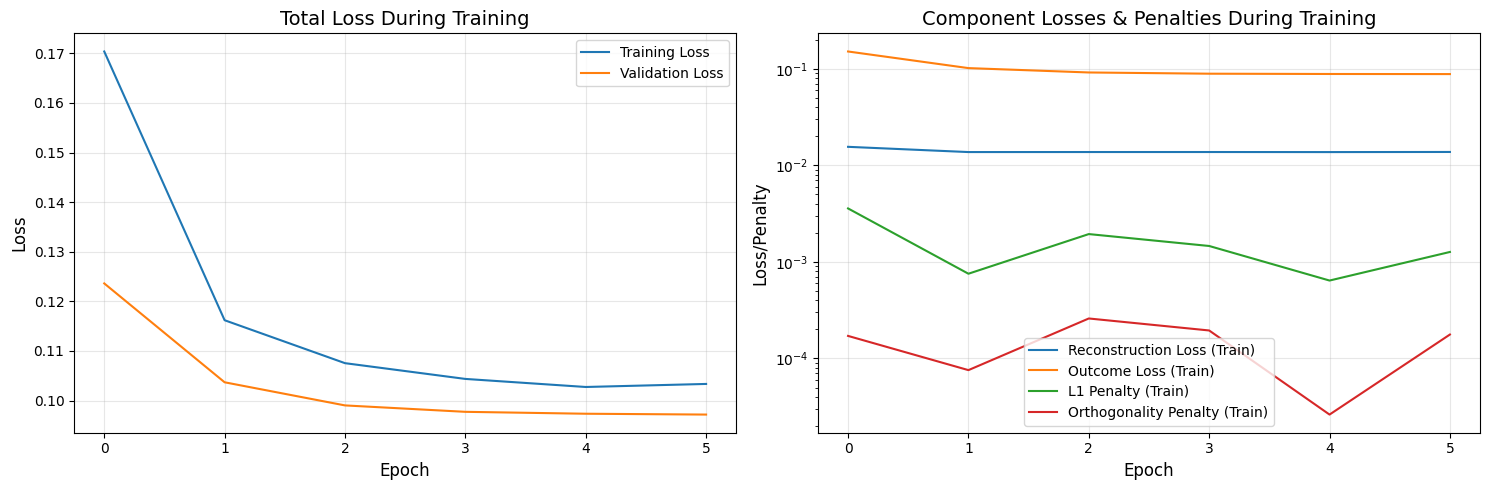

Trained model saved to interpretable_autoencoder.pth

--- Stage 3: Encoding Data with Trained Model ---
--- Encoding Data and Saving Chunks to encoded_data ---


Encoding chunks: 100%|██████████| 233/233 [00:30<00:00,  7.65 chunks/s]


--- Encoding Finished: Saved 233 encoded chunks (615621 rows) ---

--- Stage 4: Analyzing Latent Space ---
--- Analyzing Latent Space (using encoded chunks) ---
Analyzing encoder weights for feature importance...


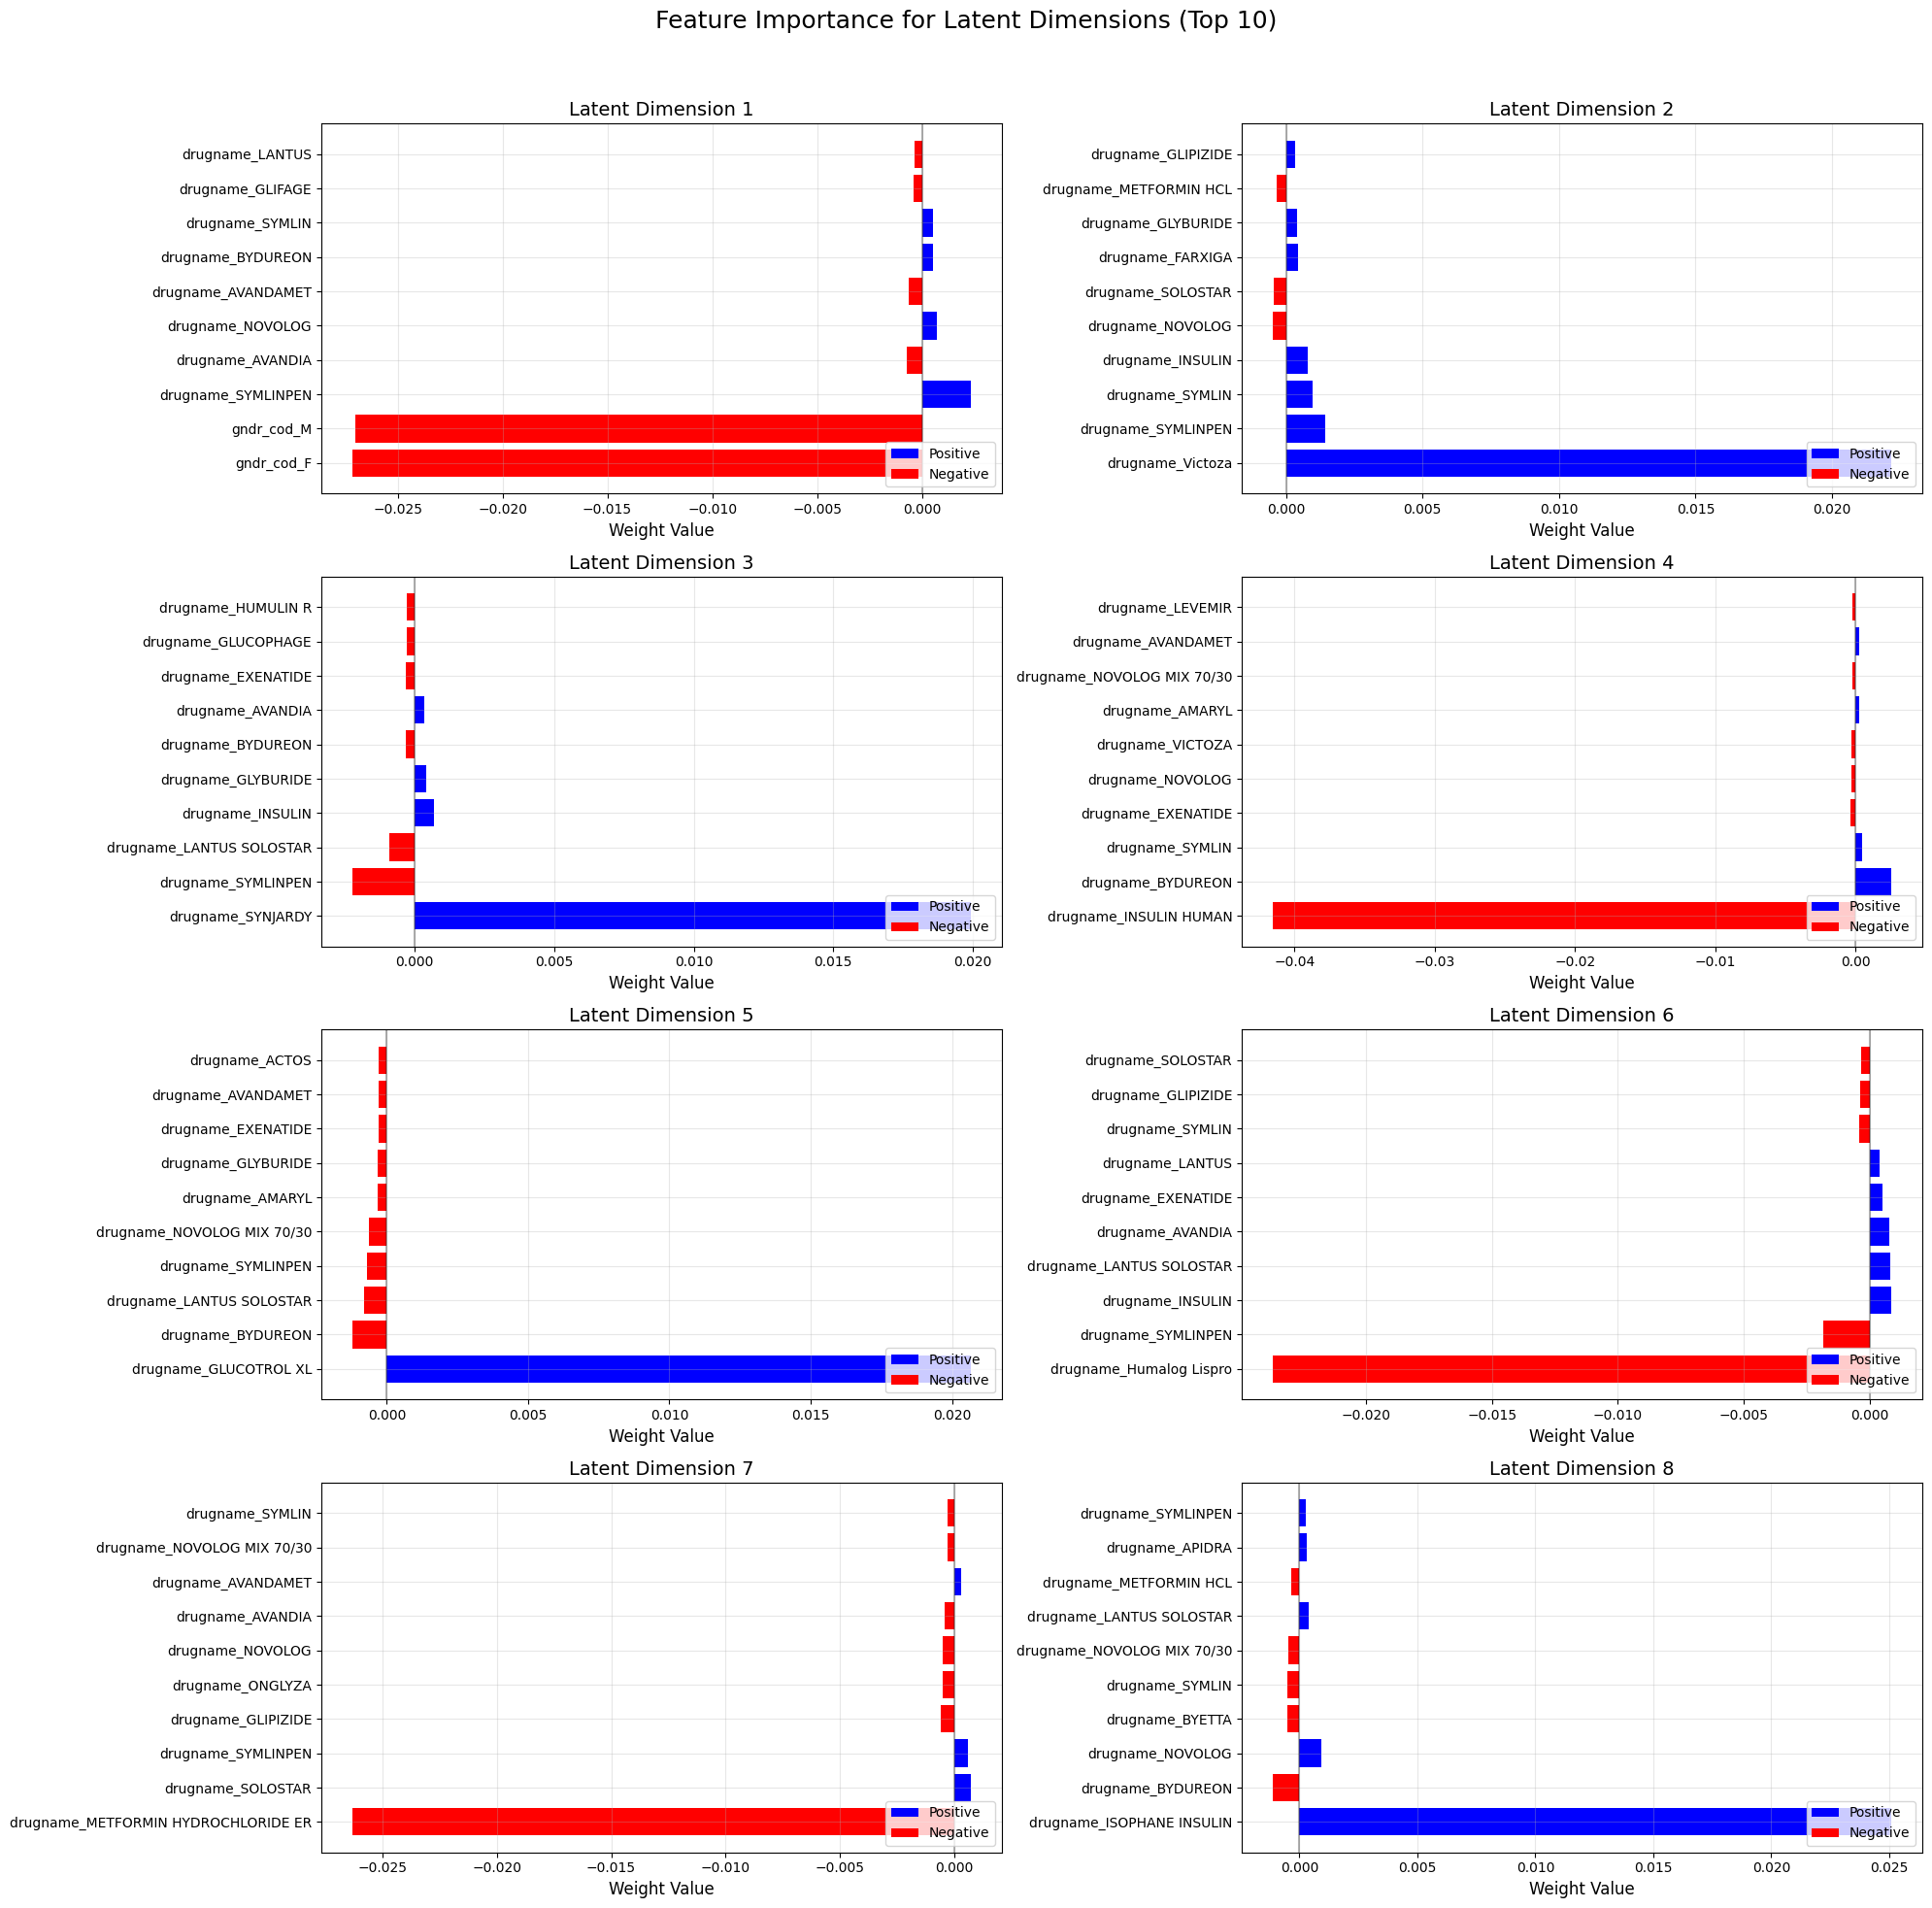

Calculating statistics for latent dimensions across all chunks...


Calculating Stats: 100%|██████████| 233/233 [00:17<00:00, 13.12 chunks/s]



Latent Dimension Statistics (Full Dataset):
Dimension          Mean  Std Dev       Min      Max
 Latent 1 -1.324626e-04 0.000321 -0.022610 0.002149
 Latent 2 -9.020920e-06 0.000987 -0.006851 0.022880
 Latent 3 -4.883481e-05 0.000924 -0.012811 0.020121
 Latent 4 -3.592064e-05 0.002354 -0.041692 0.006701
 Latent 5  7.753901e-07 0.000779 -0.001424 0.020829
 Latent 6  2.430132e-04 0.000390 -0.023765 0.014571
 Latent 7 -1.367674e-04 0.000356 -0.026566 0.000819
 Latent 8 -5.875908e-05 0.000828 -0.001294 0.025174
Plotting latent dimension distributions (using sample of size 5000)...


Sampling for Plots: 100%|██████████| 233/233 [00:00<00:00, 413.77 files/s]


Sampled 4893 points for plotting.


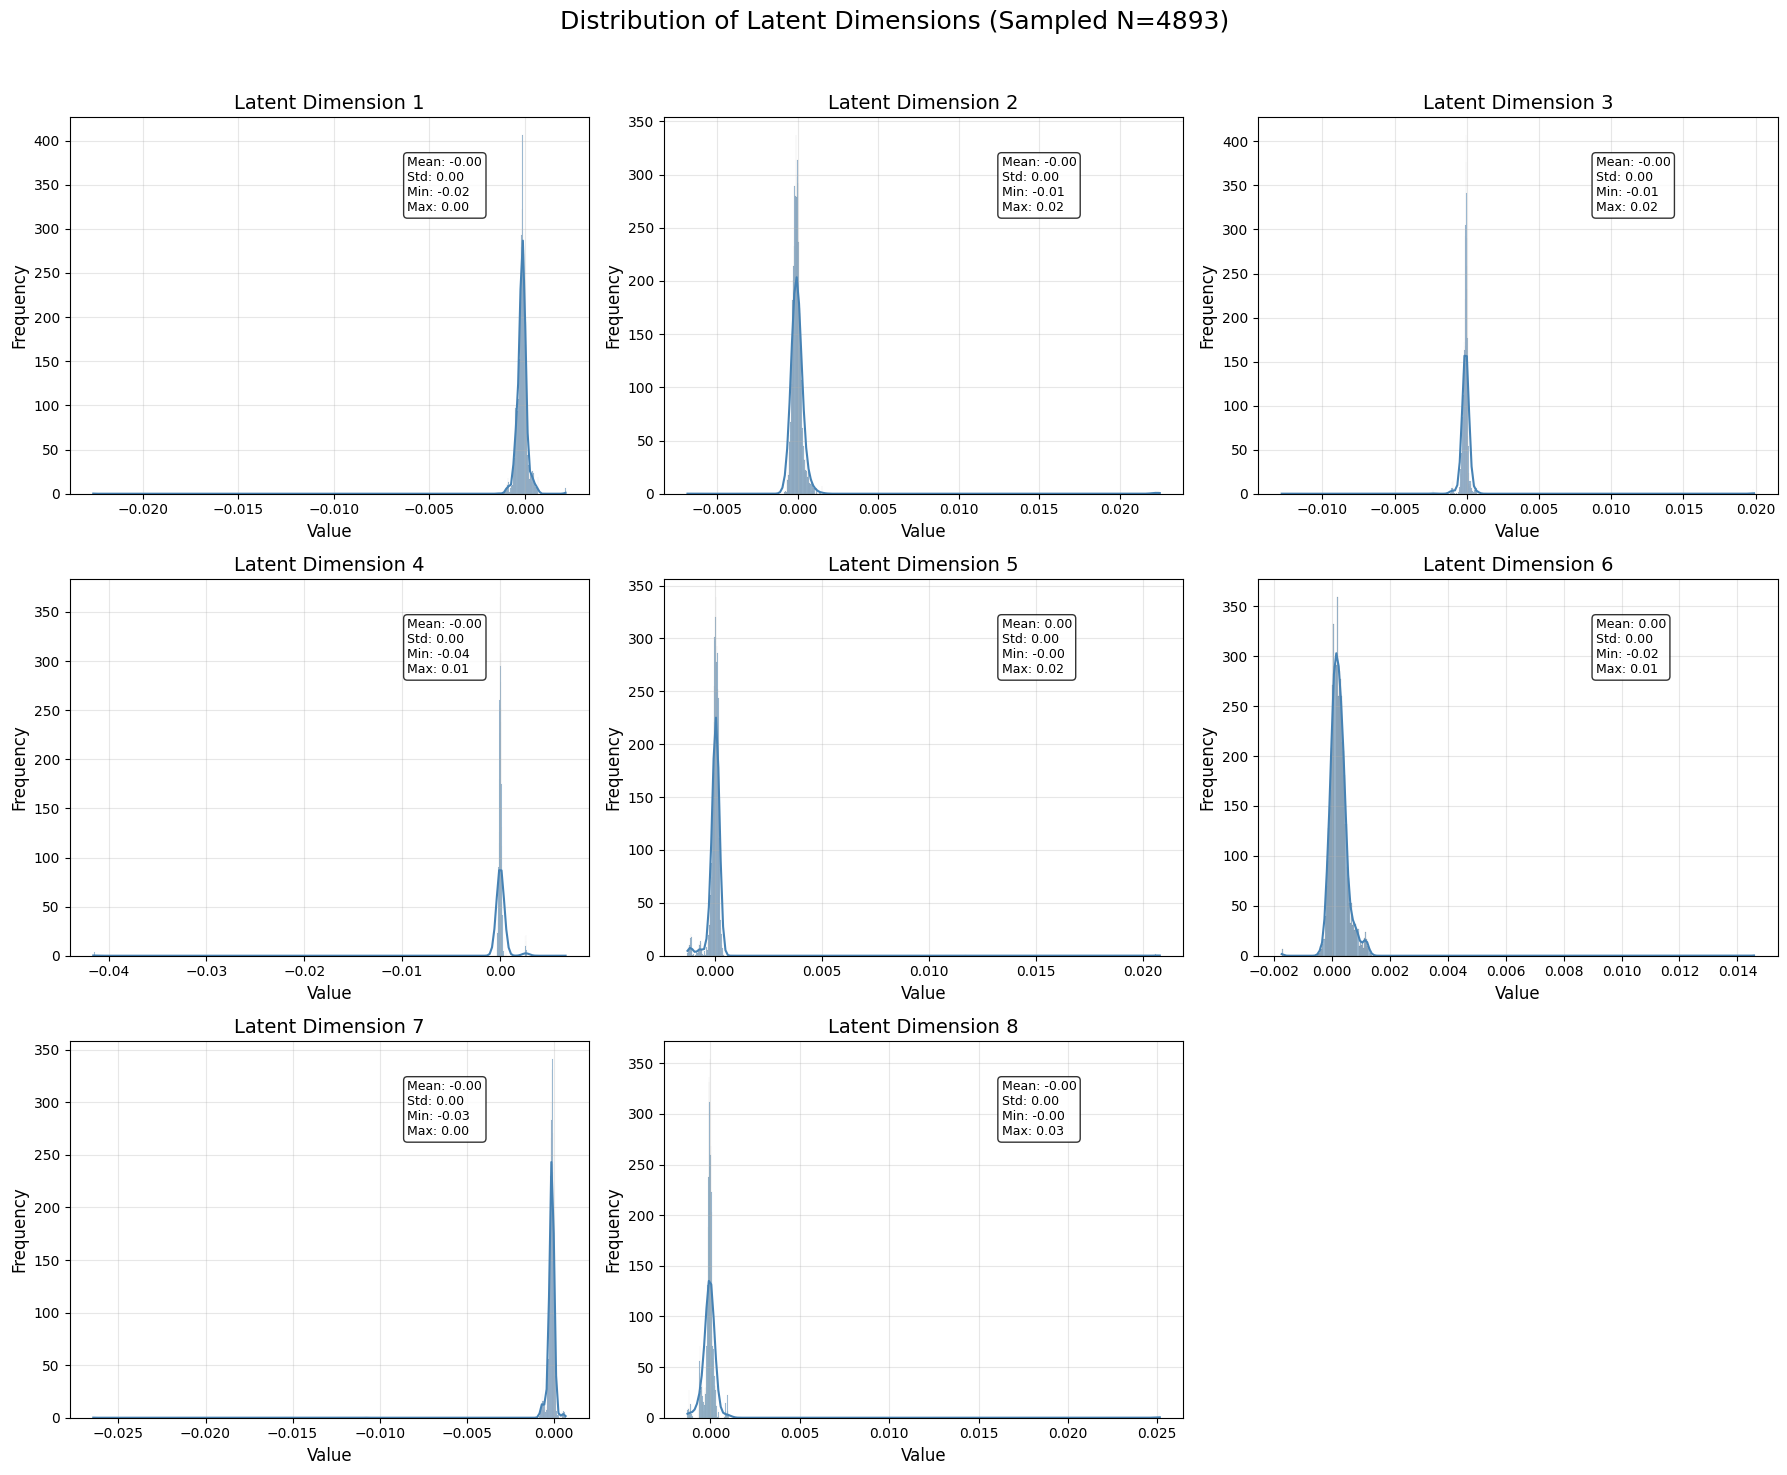

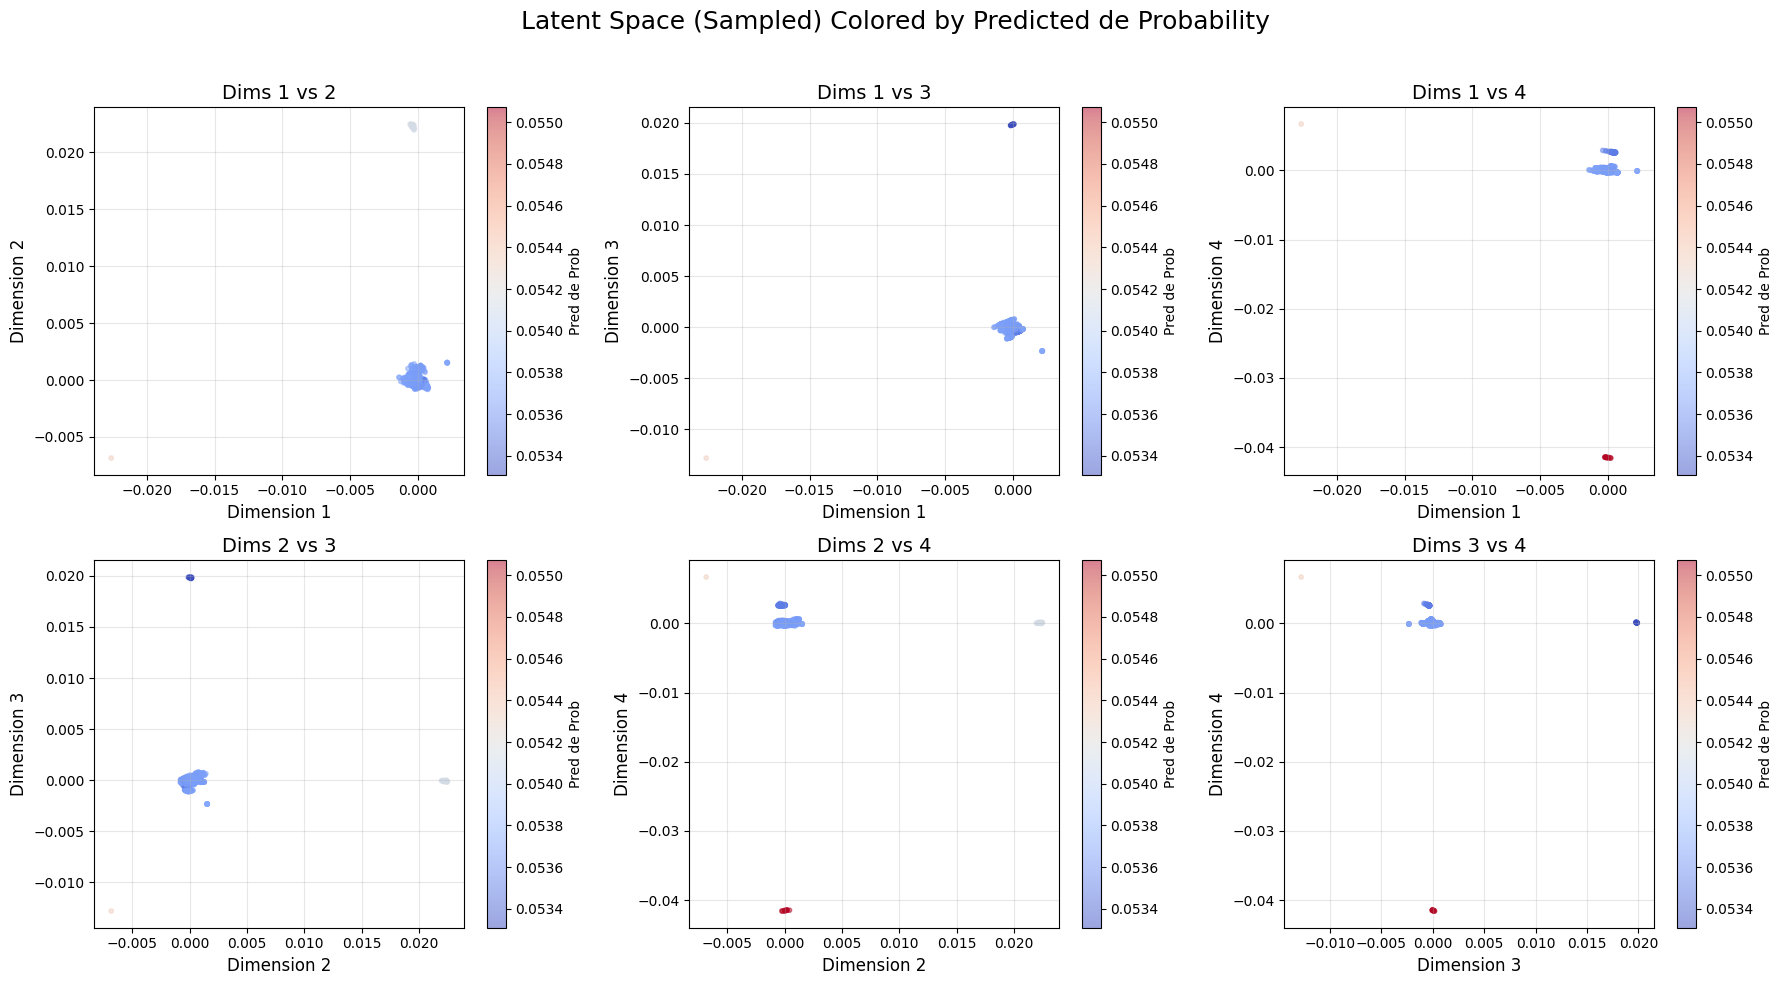

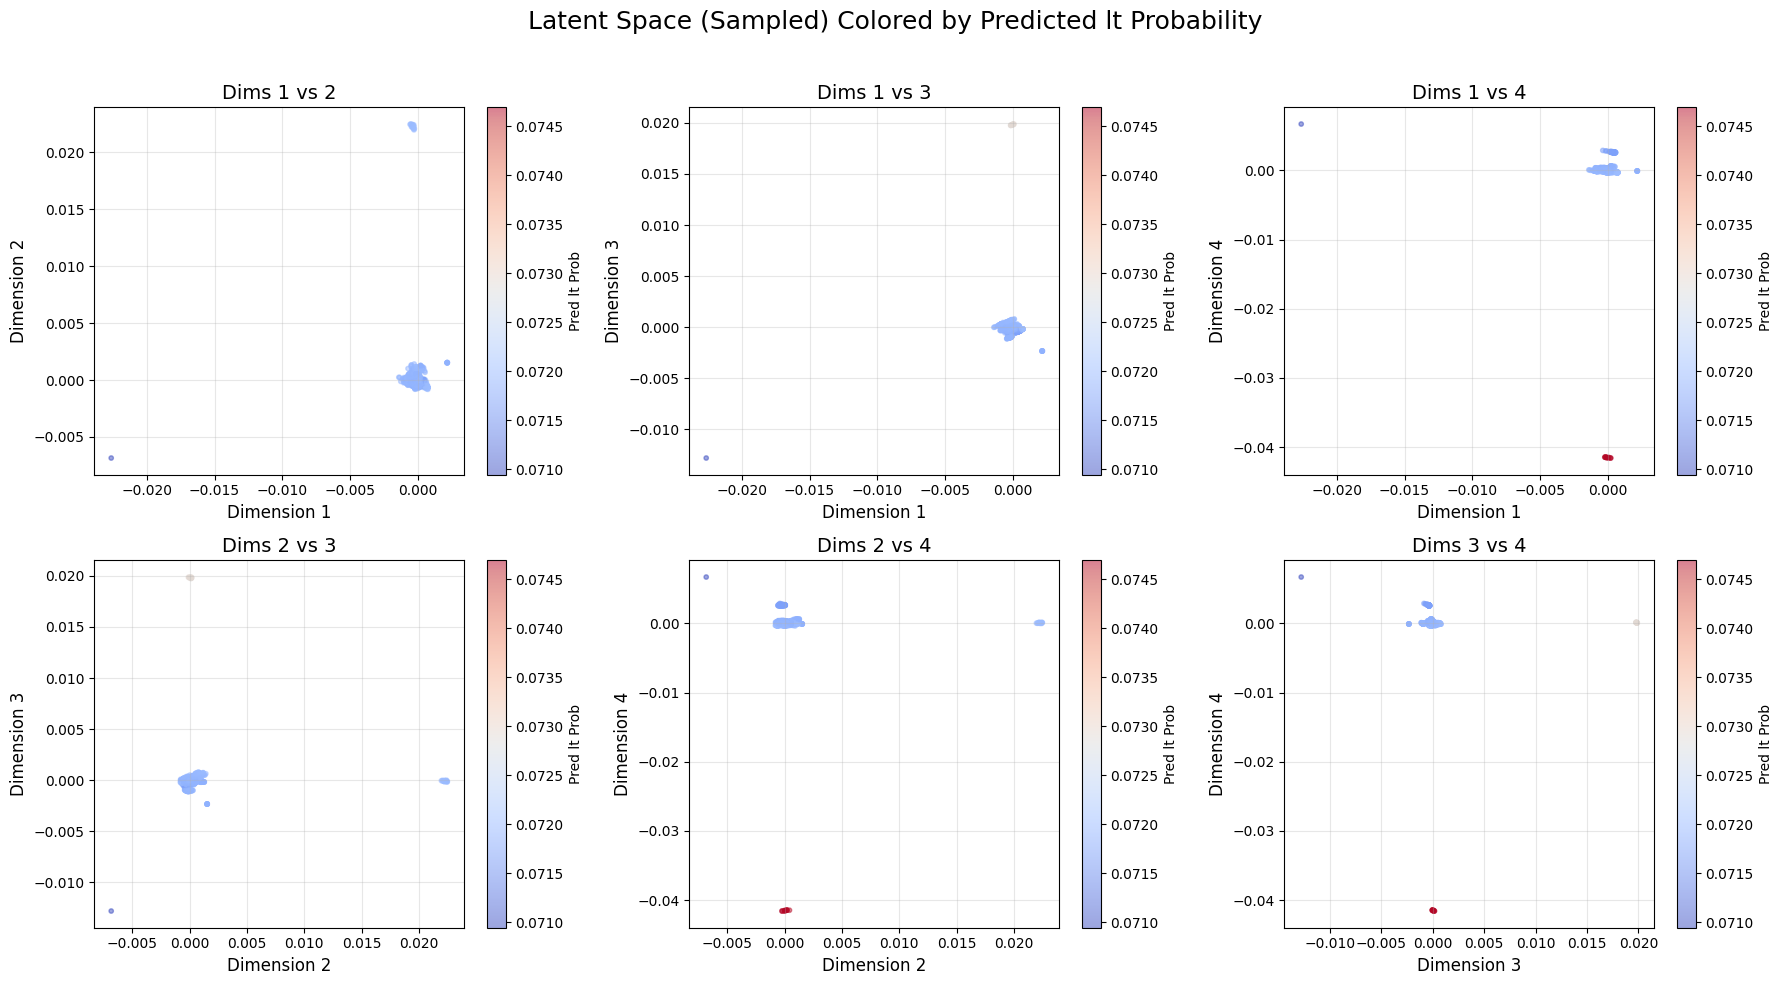

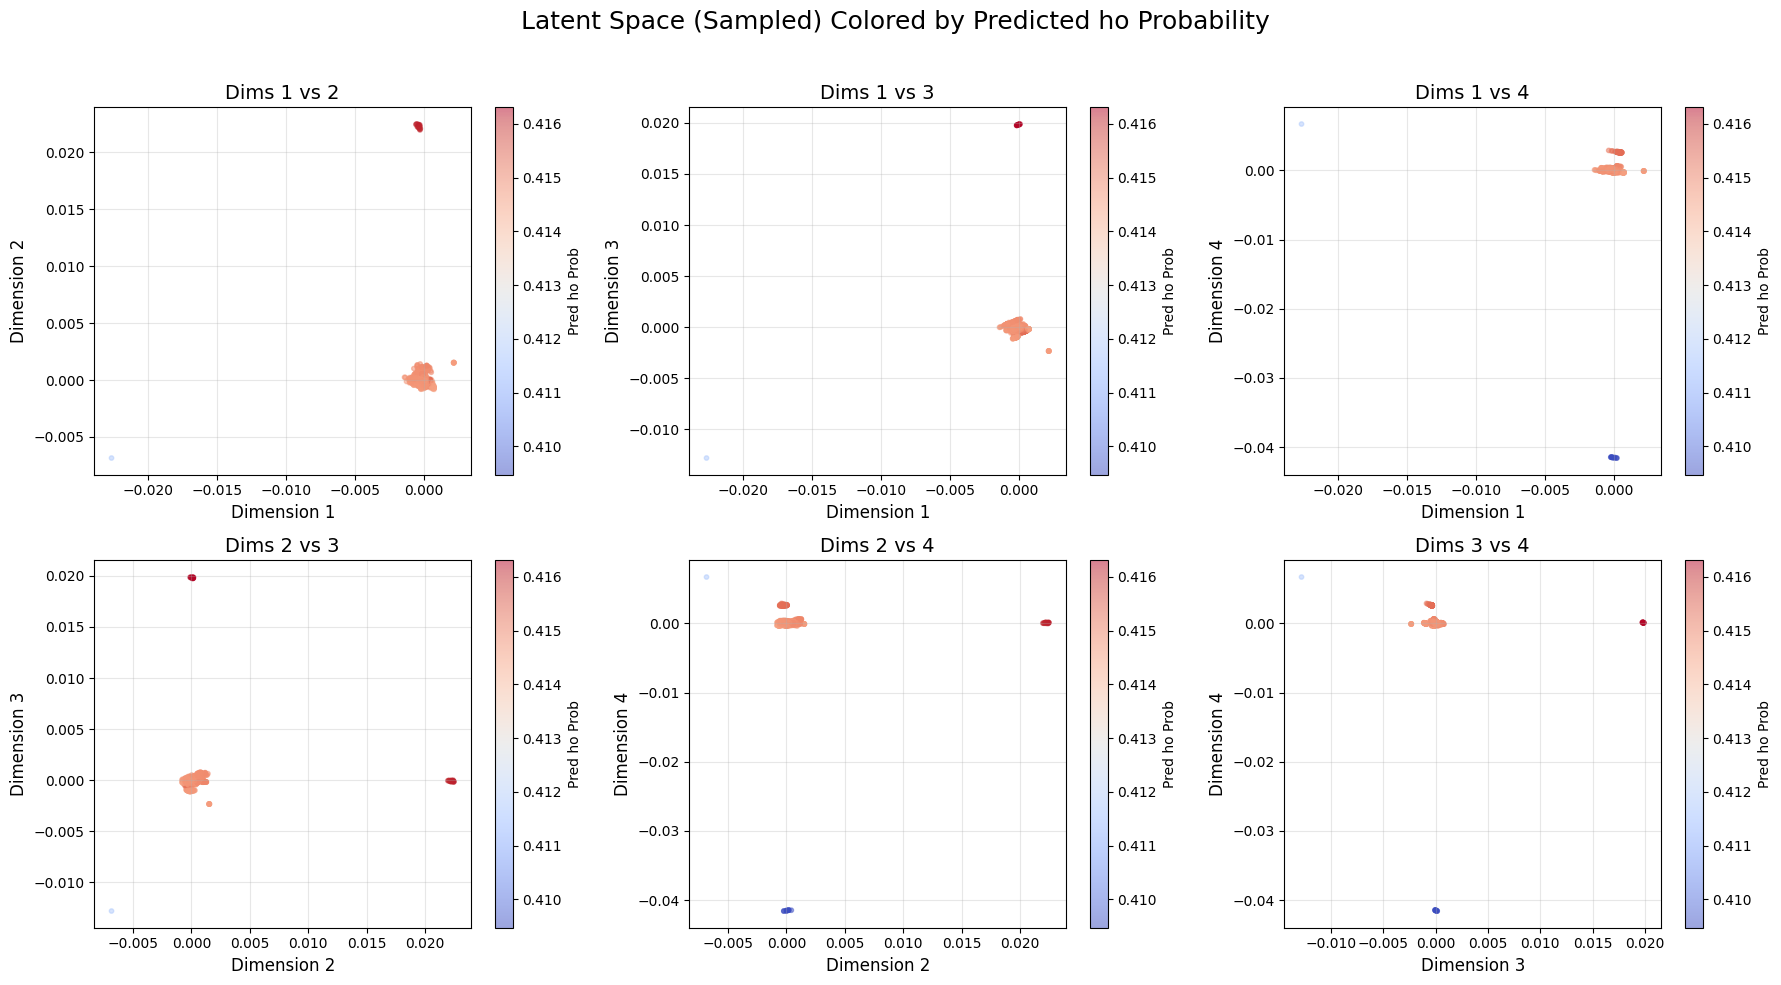

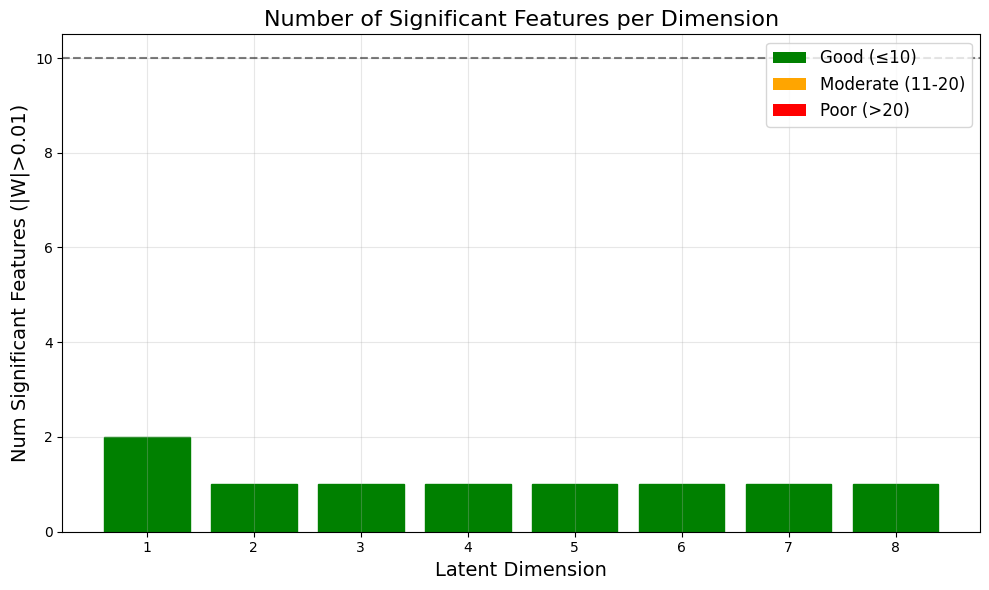


--- Stage 5: Clustering Latent Space ---
Using K-Means batch size: 4096
--- Identifying 6 Clusters using MiniBatchKMeans ---
Fitting MiniBatchKMeans and assigning clusters...


Fitting K-Means: 100%|██████████| 233/233 [00:19<00:00, 11.98 chunks/s]


Assigning cluster labels to data...


Assigning Clusters: 100%|██████████| 233/233 [00:22<00:00, 10.25 chunks/s]


Finished assigning clusters. Saved 233 chunks (615621 rows).


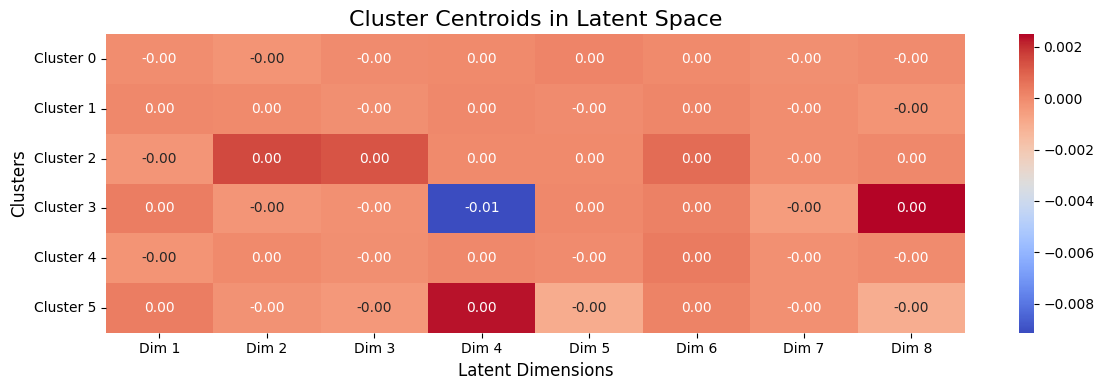

Calculating adverse event rates per cluster...


Aggregating Outcomes: 100%|██████████| 233/233 [00:17<00:00, 13.31 chunks/s]


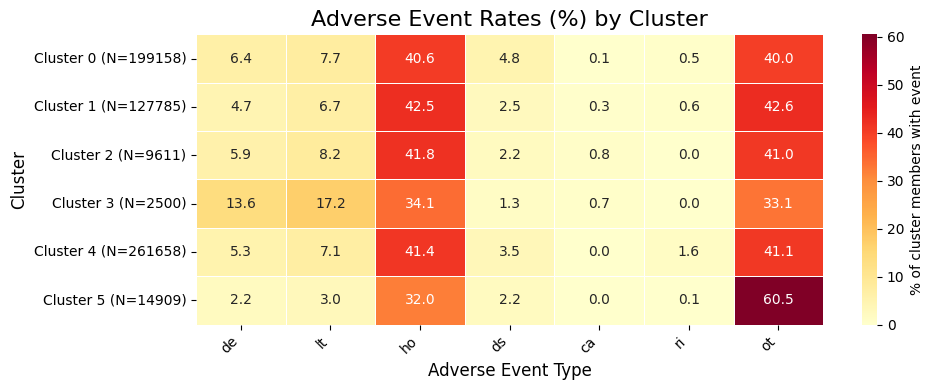

Plotting cluster assignments (using sample of size 5000)...


Sampling for Cluster Plots: 100%|██████████| 233/233 [00:00<00:00, 396.01 files/s]


Sampled 4893 points for cluster plotting.


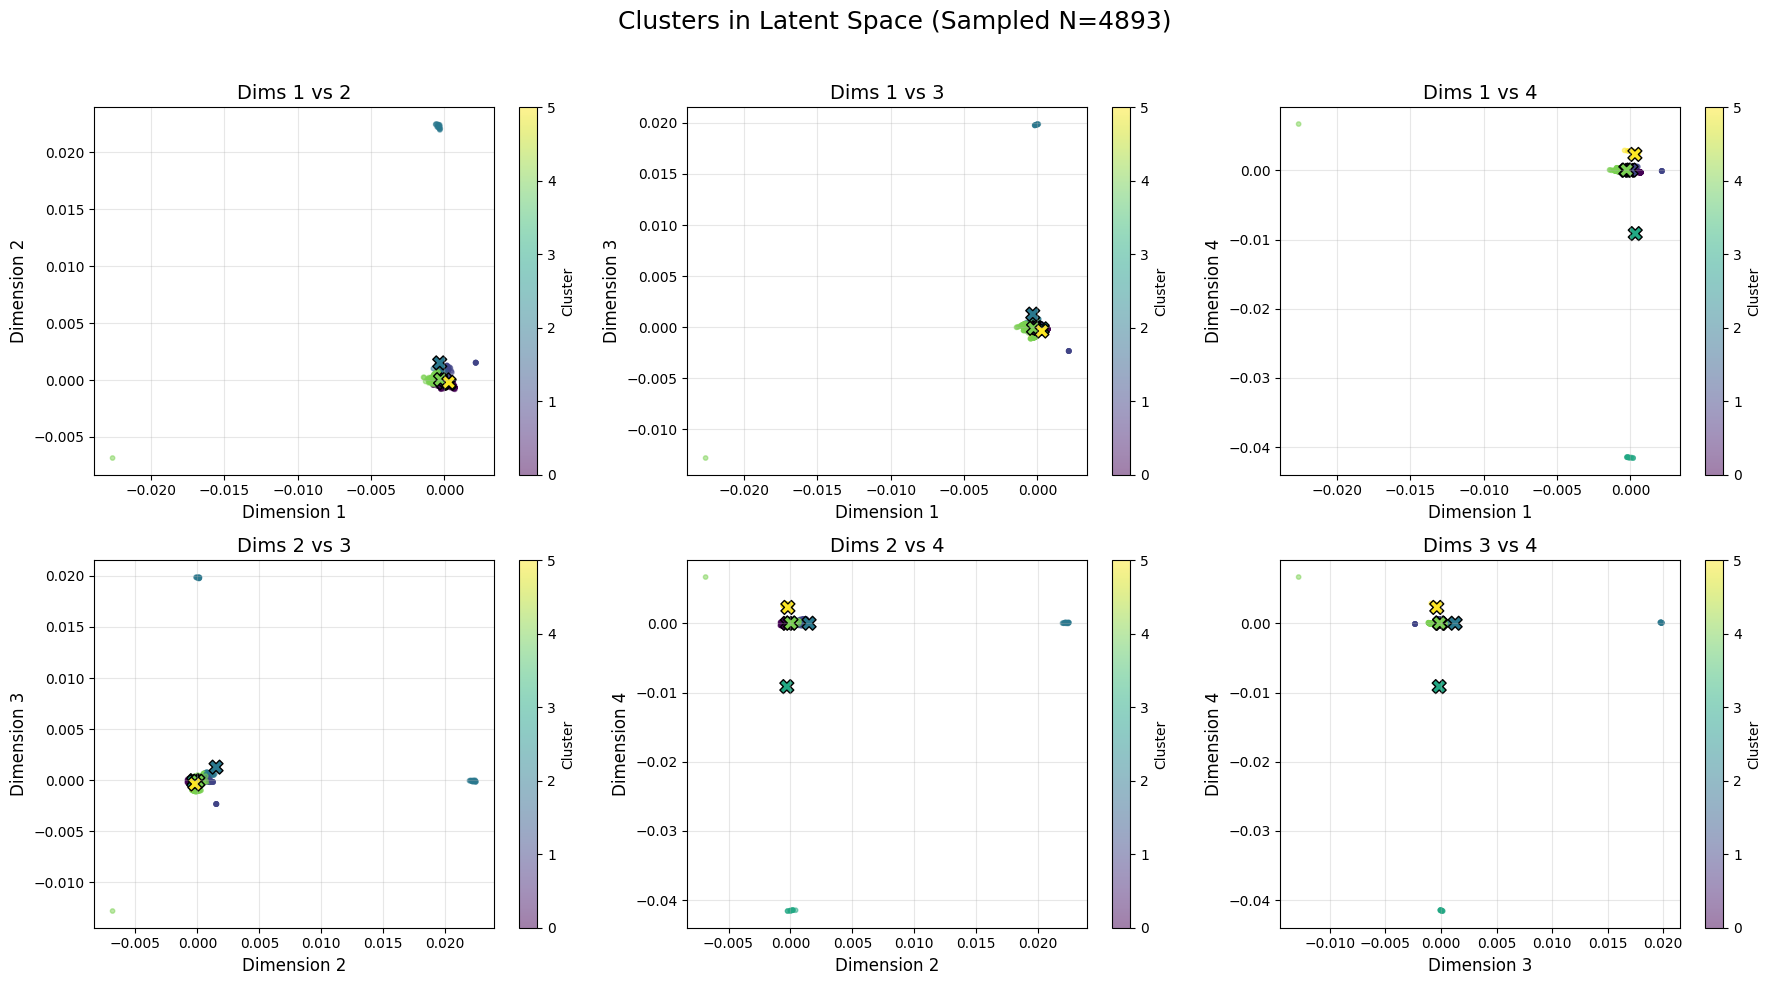

Interpreting clusters based on feature influence...


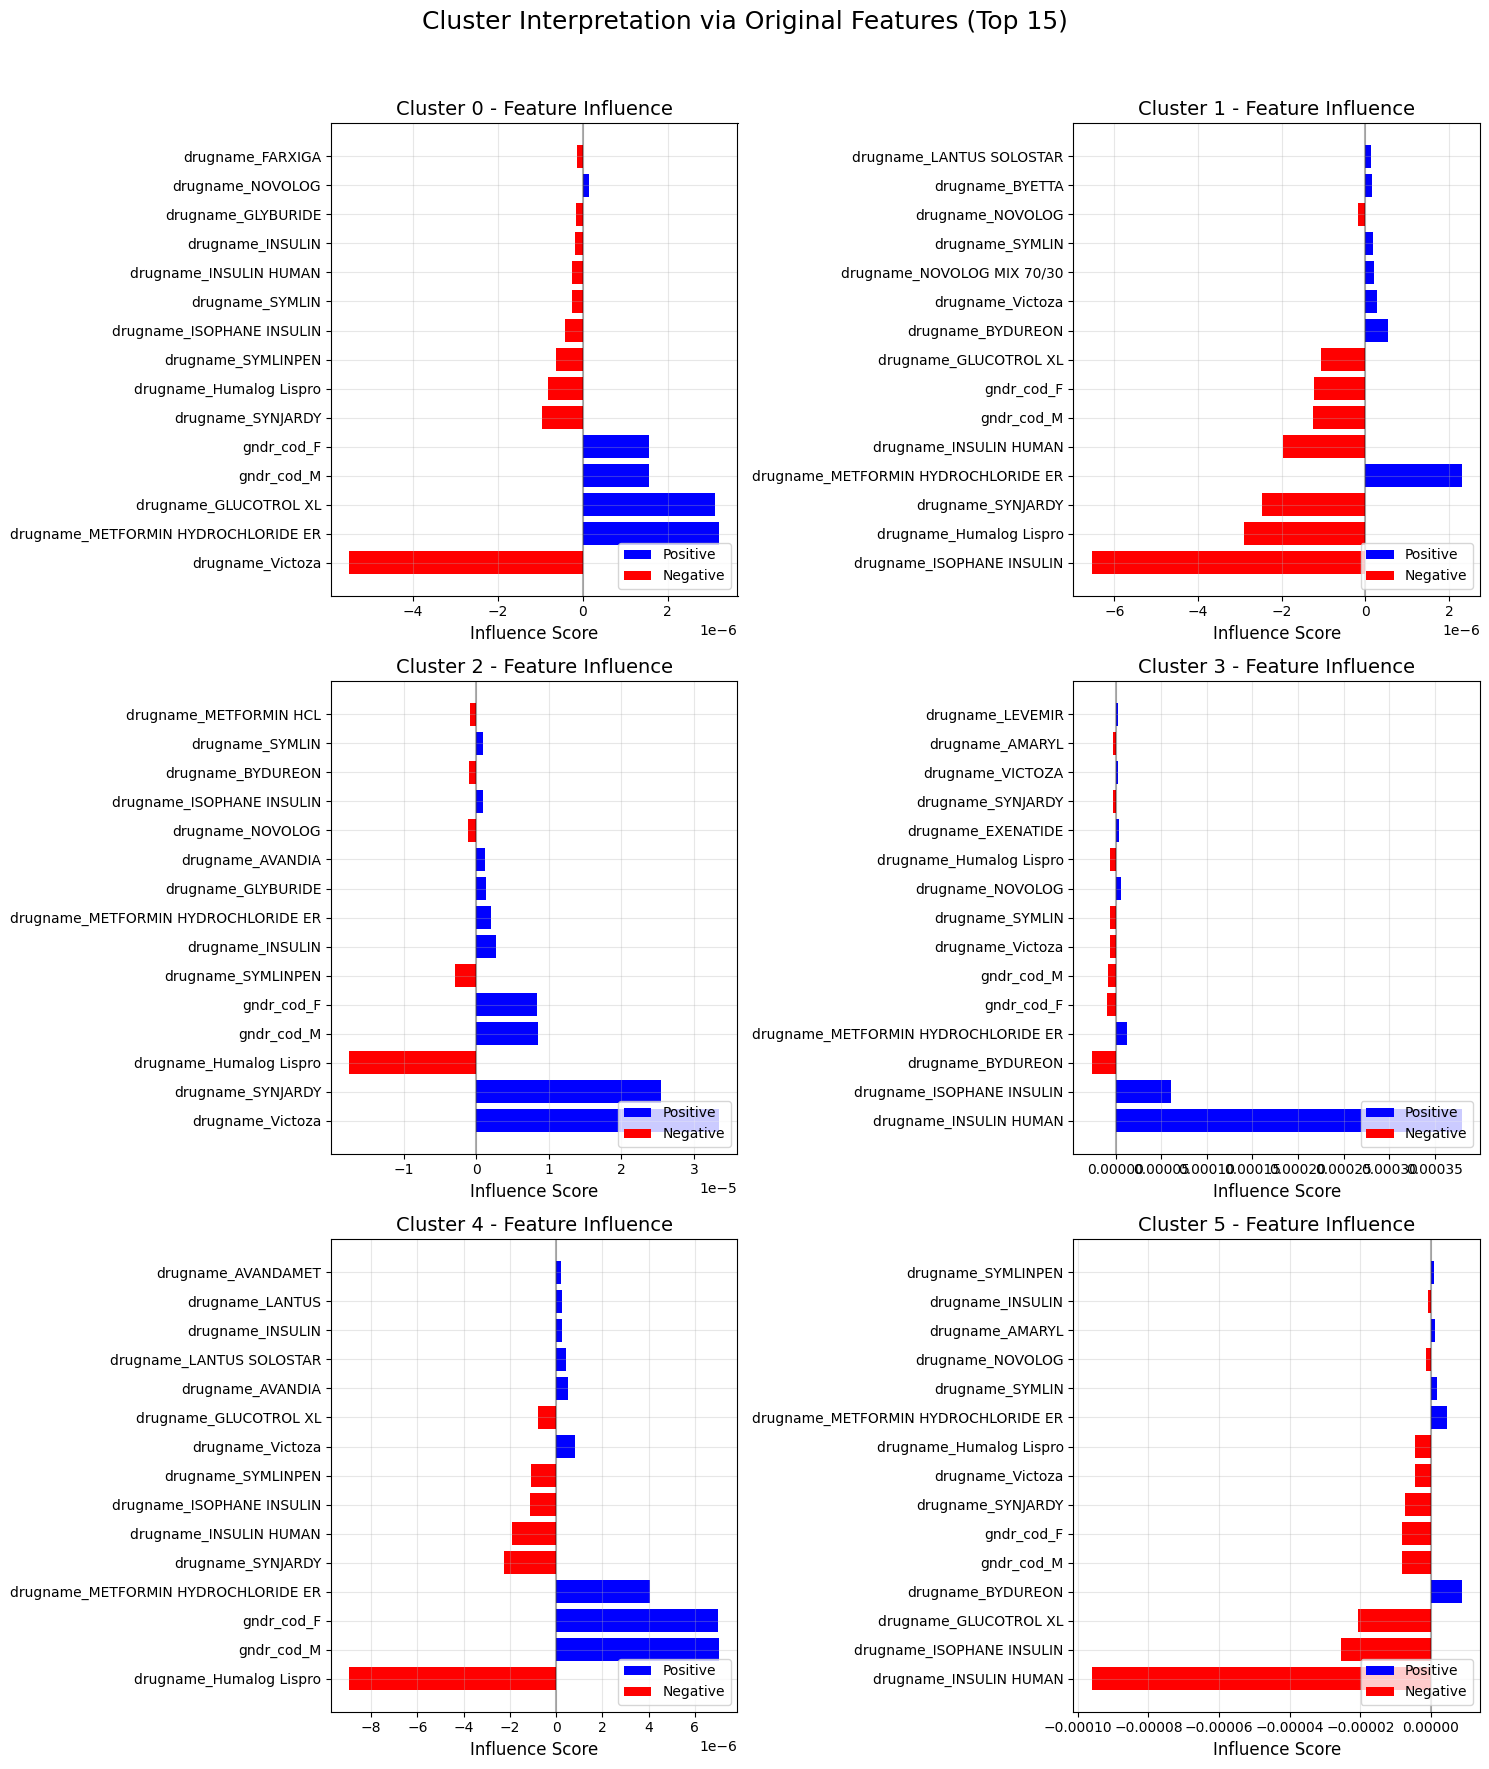


--- Stage 6: Evaluating Model Performance ---

--- Evaluating Model Performance (Chunked) ---


Evaluating Chunks: 100%|██████████| 233/233 [00:28<00:00,  8.26 chunks/s]


Evaluation completed on 615621 samples.

===== MODEL PERFORMANCE EVALUATION =====
          outcome  accuracy  pearson_correlation  p_value
               de    0.9450               0.0276   0.0000
               lt    0.9281               0.0325   0.0000
               ho    0.4110               0.0052   0.0000
               ds    0.9637               0.0044   0.0006
               ca    0.9989              -0.0082   0.0000
               ri    0.9901               0.0094   0.0000
               ot    0.4149               0.0205   0.0000
Average / Overall    0.8074               0.0130      NaN

Analysis complete.


In [12]:
if __name__ == "__main__":
    # Add cleanup at the very beginning to ensure clean state if dirs exist
    cleanup_dir(PROCESSED_DATA_DIR)
    cleanup_dir(ENCODED_DATA_DIR)
    cleanup_dir(CLUSTER_ASSIGNMENTS_DIR)
    processed_files, final_feature_names, target_features = main(160)

In [8]:
import joblib
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression # Use standard LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # Good practice for Logistic Regression
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import pearsonr
import gc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define RANDOM_SEED if not already defined
RANDOM_SEED = 560

def load_all_processed_data(processed_files, final_feature_names, target_features):
    """
    Loads and concatenates all processed data chunks into memory.

    Args:
        processed_files (list): List of paths to processed parquet files.
        final_feature_names (list): List of feature column names.
        target_features (list): List of target column names.

    Returns:
        tuple: (X_all, y_all) NumPy arrays containing all features and targets,
               or (None, None) if loading fails or data is empty.
    """
    print(f"--- Loading {len(processed_files)} processed data chunks into memory ---")
    X_list = []
    y_list = []
    expected_num_features = len(final_feature_names)

    pbar = tqdm(processed_files, desc="Loading Chunks", unit=" chunks")
    for file_path in pbar:
        try:
            chunk_df = pd.read_parquet(file_path)

            # --- Validation ---
            # Check if all expected feature columns exist
            missing_features = [col for col in final_feature_names if col not in chunk_df.columns]
            if missing_features:
                print(f"Warning: Missing feature columns {missing_features} in {file_path}. Skipping chunk.")
                continue
            # Check if all target columns exist
            missing_targets = [col for col in target_features if col not in chunk_df.columns]
            if missing_targets:
                 print(f"Warning: Missing target columns {missing_targets} in {file_path}. Skipping chunk.")
                 continue
            # Check feature dimension
            if chunk_df[final_feature_names].shape[1] != expected_num_features:
                 print(f"Warning: Incorrect feature dimension in {file_path} ({chunk_df[final_feature_names].shape[1]} vs {expected_num_features}). Skipping.")
                 continue
            # --------------

            X_list.append(chunk_df[final_feature_names])
            y_list.append(chunk_df[target_features])

            del chunk_df # Cleanup memory
            gc.collect()

        except FileNotFoundError:
            print(f"Warning: Processed file not found: {file_path}")
        except Exception as e:
            print(f"Warning: Error loading chunk {file_path}: {e}")
            continue

    if not X_list or not y_list:
        print("Error: No data loaded successfully. Cannot proceed.")
        return None, None

    print("Concatenating data...")
    try:
        X_all_df = pd.concat(X_list, ignore_index=True)
        y_all_df = pd.concat(y_list, ignore_index=True)
        del X_list, y_list
        gc.collect()
    except MemoryError:
         print("Error: Insufficient memory to concatenate all processed chunks.")
         return None, None
    except Exception as e:
         print(f"Error concatenating data: {e}")
         return None, None


    print(f"Initial loaded shape: X={X_all_df.shape}, y={y_all_df.shape}")

    # --- Final NA Check on combined data ---
    print("Checking for NaNs in combined data...")
    initial_rows = len(X_all_df)
    # Combine features and targets for joint NA drop
    combined_df = pd.concat([X_all_df, y_all_df], axis=1)
    combined_df.dropna(inplace=True)
    final_rows = len(combined_df)
    if final_rows < initial_rows:
        print(f"Dropped {initial_rows - final_rows} rows due to NaNs in combined data.")

    if combined_df.empty:
        print("Error: All data dropped due to NaNs or no data loaded. Cannot train models.")
        return None, None

    X_all = combined_df[final_feature_names].values.astype(np.float32)
    y_all = combined_df[target_features].values.astype(np.int32)
    del X_all_df, y_all_df, combined_df
    gc.collect()

    print(f"Final data shape after NA drop: X={X_all.shape}, y={y_all.shape}")
    return X_all, y_all

def train_logistic_regression_baseline(X_all, y_all, target_features, C=1.0):
    """
    Trains multiple Logistic Regression models (one per target) on the complete dataset.

    Args:
        X_all (np.ndarray): NumPy array of all features.
        y_all (np.ndarray): NumPy array of all targets.
        target_features (list): List of target column names.
        C (float): Inverse of regularization strength for LogisticRegression.

    Returns:
        dict: A dictionary mapping target feature names to trained LogisticRegression models (within Pipelines).
    """
    print(f"\n--- Training Logistic Regression Baseline (Full Data Fit) ---")
    models = {}
    num_samples, num_features = X_all.shape
    num_targets = y_all.shape[1]

    if num_samples == 0:
        raise ValueError("Cannot train models on zero samples.")

    print(f"Training {num_targets} models on {num_samples} samples with {num_features} features.")

    for i, target_col in enumerate(target_features):
        print(f"Training model for target: {target_col} ({i+1}/{num_targets})...")
        y_target = y_all[:, i]

        # Check if target has more than one class
        unique_classes = np.unique(y_target)
        if len(unique_classes) <= 1:
            print(f"Warning: Target '{target_col}' has only one class ({unique_classes}). Skipping training for this target.")
            models[target_col] = None # Mark model as None if not trainable
            continue

        # Create a pipeline: StandardScaler + LogisticRegression
        # Use a solver suitable for potentially large datasets if needed, like 'saga'
        pipeline = make_pipeline(
            StandardScaler(), # Scale features before fitting
            LogisticRegression(
                C=C,                 # Regularization strength
                solver='liblinear',  # Good default for binary classification
                random_state=RANDOM_SEED,
                max_iter=200,        # Increase max_iter if needed
                class_weight='balanced' # Helps with imbalanced classes
            )
        )

        try:
            pipeline.fit(X_all, y_target)
            models[target_col] = pipeline
            print(f"  Successfully trained model for {target_col}.")
        except Exception as e:
            print(f"Error training model for target '{target_col}': {e}")
            models[target_col] = None # Mark as None on error

    print("--- Baseline Model Training Finished ---")
    return models

def evaluate_logistic_regression_baseline(models, X_all, y_all, target_features, threshold=0.5):
    """
    Evaluates multiple trained Logistic Regression models on the complete dataset.

    Args:
        models (dict): Dictionary of trained LogisticRegression models (Pipelines).
        X_all (np.ndarray): NumPy array of all features.
        y_all (np.ndarray): NumPy array of all targets.
        target_features (list): List of target column names.
        threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
        dict: Dictionary with evaluation metrics (accuracy, Pearson correlation).
    """
    print("\n--- Evaluating Logistic Regression Baseline (Full Data) ---")

    num_samples, num_features = X_all.shape
    num_outcomes = y_all.shape[1]

    # Store predictions probabilities here
    all_outcome_preds = np.full((num_samples, num_outcomes), 0.5, dtype=np.float32) # Default to 0.5

    print("Generating predictions...")
    for i, target_col in enumerate(target_features):
        pipeline = models.get(target_col) # Use .get() to handle None models
        if pipeline is not None:
            try:
                # Get probability of the positive class (class 1)
                y_pred_proba = pipeline.predict_proba(X_all)[:, 1]
                all_outcome_preds[:, i] = y_pred_proba
            except Exception as e:
                print(f"Error predicting probabilities for {target_col}: {e}. Predictions remain 0.5.")
        else:
            print(f"Model for target '{target_col}' was not trained or failed. Predictions remain 0.5.")

    # --- Calculate Metrics ---
    print("Calculating baseline metrics...")
    binary_preds = (all_outcome_preds >= threshold).astype(int)
    all_outcome_true = y_all # Use the input y_all directly
    outcome_metrics = []

    for i in range(num_outcomes):
        target_name = target_features[i]
        true_col = all_outcome_true[:, i]
        pred_col = all_outcome_preds[:, i]
        pred_binary_col = binary_preds[:, i]

        # Accuracy
        try:
            # Check if true_col has valid values before calculating accuracy
            if len(np.unique(true_col)) > 0: # Ensure there's data
                 acc = accuracy_score(true_col, pred_binary_col)
            else:
                 acc = np.nan
        except Exception as e:
            print(f"Warning (Baseline Acc {target_name}): {e}")
            acc = np.nan

        # Pearson Correlation
        valid_corr = False
        if len(np.unique(true_col)) > 1 and len(np.unique(pred_col)) > 1:
            if not np.isnan(true_col).any() and not np.isnan(pred_col).any():
                 try:
                     pearson_corr, p_value = pearsonr(true_col, pred_col)
                     valid_corr = True
                 except ValueError as e:
                     print(f"Warning (Baseline Pearson {target_name}): {e}")
                     pearson_corr, p_value = np.nan, np.nan
            else:
                 pearson_corr, p_value = np.nan, np.nan
        else:
            pearson_corr, p_value = np.nan, np.nan

        outcome_metrics.append({
           'outcome': target_name,
           'accuracy': acc,
           'pearson_correlation': pearson_corr if valid_corr else np.nan,
           'p_value': p_value if valid_corr else np.nan
       })

    # Overall/Average Metrics
    try:
        # Check if flatten arrays are valid before calculating overall accuracy
        if all_outcome_true.size > 0 and binary_preds.size > 0:
             overall_accuracy = accuracy_score(all_outcome_true.flatten(), binary_preds.flatten())
        else:
             overall_accuracy = np.nan
    except Exception as e:
        print(f"Warning (Baseline Overall Acc): {e}")
        overall_accuracy = np.nan

    avg_pearson_corr = np.nanmean([m['pearson_correlation'] for m in outcome_metrics])

    results = {
        'overall_accuracy': overall_accuracy,
        'avg_pearson_correlation': avg_pearson_corr,
        'outcome_metrics': outcome_metrics,
    }

    # --- Format and Print Results ---
    summary_df = pd.DataFrame(outcome_metrics)
    avg_row = pd.DataFrame([{
        'outcome': 'Average / Overall',
        'accuracy': overall_accuracy,
        'pearson_correlation': avg_pearson_corr,
        'p_value': np.nan
    }])
    summary_df = pd.concat([summary_df, avg_row], ignore_index=True)

    print("\n===== BASELINE LOGISTIC REGRESSION PERFORMANCE (Full Data Fit) =====")
    print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if not pd.isna(x) else " N/A "))

    return results


In [4]:
# --- Assuming these variables exist from preprocessing ---
# processed_files = [...]
# final_feature_names = [...]
# target_features = [...]
# --------------------------------------------------------

# 1. Load all processed data
X_baseline, y_baseline = load_all_processed_data(processed_files, final_feature_names, target_features)

# Proceed only if data loading was successful
if X_baseline is not None and y_baseline is not None:

    # 2. Train the baseline models on the loaded data
    baseline_models = train_logistic_regression_baseline(
        X_all=X_baseline,
        y_all=y_baseline,
        target_features=target_features
        # You can adjust C regularization: C=0.1 for stronger regularization
    )

    # 3. Evaluate the baseline models
    baseline_results = evaluate_logistic_regression_baseline(
        models=baseline_models,
        X_all=X_baseline,
        y_all=y_baseline,
        target_features=target_features
    )

    # Optional: Save the trained baseline models
    # try:
    #     joblib.dump(baseline_models, 'baseline_logistic_models_fulldata.joblib')
    #     print("Saved baseline models (full data fit).")
    # except Exception as e:
    #     print(f"Error saving baseline models: {e}")

else:
    print("Baseline model training and evaluation skipped due to data loading issues.")

# Now 'baseline_results' holds the performance metrics for comparison

--- Loading 233 processed data chunks into memory ---


Loading Chunks: 100%|██████████| 233/233 [00:20<00:00, 11.10 chunks/s]


Concatenating data...
Initial loaded shape: X=(615621, 164), y=(615621, 7)
Checking for NaNs in combined data...
Final data shape after NA drop: X=(615621, 164), y=(615621, 7)

--- Training Logistic Regression Baseline (Full Data Fit) ---
Training 7 models on 615621 samples with 164 features.
Training model for target: de (1/7)...
  Successfully trained model for de.
Training model for target: lt (2/7)...
  Successfully trained model for lt.
Training model for target: ho (3/7)...
  Successfully trained model for ho.
Training model for target: ds (4/7)...
  Successfully trained model for ds.
Training model for target: ca (5/7)...
  Successfully trained model for ca.
Training model for target: ri (6/7)...
  Successfully trained model for ri.
Training model for target: ot (7/7)...
  Successfully trained model for ot.
--- Baseline Model Training Finished ---

--- Evaluating Logistic Regression Baseline (Full Data) ---
Generating predictions...
Calculating baseline metrics...

===== BASELIN

In [7]:
print(baseline_results)

{'overall_accuracy': 0.6720983480791869, 'avg_pearson_correlation': 0.16842857525803703, 'outcome_metrics': [{'outcome': 'de', 'accuracy': 0.6270611301433837, 'pearson_correlation': 0.16414636381831263, 'p_value': 0.0}, {'outcome': 'lt', 'accuracy': 0.535975868269601, 'pearson_correlation': 0.14643421805107842, 'p_value': 0.0}, {'outcome': 'ho', 'accuracy': 0.5553221868649705, 'pearson_correlation': 0.15187387080449127, 'p_value': 0.0}, {'outcome': 'ds', 'accuracy': 0.6128819517202955, 'pearson_correlation': 0.13443576669126134, 'p_value': 0.0}, {'outcome': 'ca', 'accuracy': 0.8862839311849335, 'pearson_correlation': 0.09582901677615738, 'p_value': 0.0}, {'outcome': 'ri', 'accuracy': 0.9226001062341928, 'pearson_correlation': 0.30146441952522945, 'p_value': 0.0}, {'outcome': 'ot', 'accuracy': 0.5645632621369316, 'pearson_correlation': 0.18481637113972865, 'p_value': 0.0}]}


{'overall_accuracy': 0.6720983480791869,
 'avg_pearson_correlation': 0.16842857525803703,
 'outcome_metrics': [{'outcome': 'de',
   'accuracy': 0.6270611301433837,
   'pearson_correlation': 0.16414636381831263,
   'p_value': 0.0},
  {'outcome': 'lt',
   'accuracy': 0.535975868269601,
   'pearson_correlation': 0.14643421805107842,
   'p_value': 0.0},
  {'outcome': 'ho',
   'accuracy': 0.5553221868649705,
   'pearson_correlation': 0.15187387080449127,
   'p_value': 0.0},
  {'outcome': 'ds',
   'accuracy': 0.6128819517202955,
   'pearson_correlation': 0.13443576669126134,
   'p_value': 0.0},
  {'outcome': 'ca',
   'accuracy': 0.8862839311849335,
   'pearson_correlation': 0.09582901677615738,
   'p_value': 0.0},
  {'outcome': 'ri',
   'accuracy': 0.9226001062341928,
   'pearson_correlation': 0.30146441952522945,
   'p_value': 0.0},
  {'outcome': 'ot',
   'accuracy': 0.5645632621369316,
   'pearson_correlation': 0.18481637113972865,
   'p_value': 0.0}]}